In [85]:
#1. Use the Request library to retrieve weather data from the OpenWeatherMap API.
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from itertools import product
import plotly.express as px
import missingno as msno # for missing data
import sweetviz as sv #Sweetviz Library for EDA


from sklearn.model_selection import train_test_split
# Preprocessing Data
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import   StandardScaler, OneHotEncoder
#from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,roc_auc_score, roc_curve,classification_report
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [2]:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

In [3]:
def get_forecast_data(city_name, api_key):
    base_url = "http://api.openweathermap.org/data/2.5/forecast"
    params = {
        "q": city_name,
        "appid": api_key,
        "units": "metric",  # Use Celsius for temperature
        "lang" :"fr"
    }
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Failed to retrieve data. Check your API key or city name.")
        return None

In [6]:
api_key = '6e36dd13aff0a4ede85ab7aa6cb463f3'
city_name = 'Dakar'
forecast_data = get_forecast_data(city_name, api_key)

In [7]:
data1 = forecast_data['list']
data1[0]

{'dt': 1694444400,
 'main': {'temp': 30.54,
  'feels_like': 37.52,
  'temp_min': 28.64,
  'temp_max': 30.54,
  'pressure': 1013,
  'sea_level': 1013,
  'grnd_level': 1010,
  'humidity': 74,
  'temp_kf': 1.9},
 'weather': [{'id': 500,
   'main': 'Rain',
   'description': 'légère pluie',
   'icon': '10d'}],
 'clouds': {'all': 86},
 'wind': {'speed': 2.08, 'deg': 228, 'gust': 1.88},
 'visibility': 10000,
 'pop': 0.52,
 'rain': {'3h': 0.38},
 'sys': {'pod': 'd'},
 'dt_txt': '2023-09-11 15:00:00'}

In [8]:
dt = []
temp = []
feels_like = []
temp_min = []
temp_max = []
pressure = []
sea_level = []
grnd_level = []
humidity = []
temp_kf = []
weather_id = []
weather_main = []
weather_description = []
weather_icon = []
clouds_all = []
wind_speed = []
wind_deg = []
wind_gust = []
visibility = []
pop = []
rain_3h=[]
#snow_3h=[]
sys_pod = []
dt_txt = []
for i in range(len(data1)):
    dt.append(data1[i]['dt'])
    temp.append(data1[i]['main']['temp'])
    feels_like.append(data1[i]['main']['feels_like']) #This temperature parameter accounts for the human perception of weather
    temp_min.append(data1[i]['main']['temp_min'])
    temp_max.append(data1[i]['main']['temp_max'])
    pressure.append(data1[i]['main']['pressure'])
    sea_level.append(data1[i]['main']['sea_level'])
    grnd_level.append(data1[i]['main']['grnd_level'])
    humidity.append(data1[i]['main']['humidity'])
    temp_kf.append(data1[i]['main']['temp_kf'])
    weather_id.append(data1[i]['weather'][0]['id'])
    weather_main.append(data1[i]['weather'][0]['main'])
    weather_description.append(data1[i]['weather'][0]['description'])
    weather_icon.append(data1[i]['weather'][0]['icon'])
    clouds_all.append(data1[i]['clouds']['all'])
    wind_speed.append(data1[i]['wind']['speed'])
    wind_deg.append(data1[i]['wind']['deg'])
    wind_gust.append(data1[i]['wind']['gust'])
    visibility.append(data1[i]['visibility'])
    pop.append(data1[i]['pop'])  #Probability of precipitation
    sys_pod.append(data1[i]['sys']['pod']) # Part of the day (n - night, d - day)
    dt_txt.append(data1[i]['dt_txt']) #Time of data forecasted, ISO, UTC
    key = 'rain'
    if key in data1[i]:
        rain_3h.append(data1[i]['rain']['3h']) #Rain volume for last 3 hours, mm
    else:
        rain_3h.append(0)
    #snow_3h.append(data1[i]['snow']) #Snow volume for last 3 hours. 
    
    

In [61]:
d = {
    
    'dt': dt, 
    'temp': temp, 
    'feels_like': feels_like, 
    'temp_min ':temp_min,
    'temp_max': temp_max, 
    'pressure':pressure,
    'sea_level': sea_level, 
    'grnd_level': grnd_level,
    'humidity': humidity,
    'temp_kf': temp_kf,
    'weather_id': weather_id,
    'weather_main': weather_main,
    'weather_description': weather_description,
    'weather_icon': weather_icon,
    'clouds_all': clouds_all,
    'wind_speed': wind_speed,
    'wind_deg': wind_deg,
    'wind_gust': wind_gust,
    'visibility': visibility,
    'pop': pop, 
    "rain_3h":rain_3h, 
    #"snow_3h":snow_3h, 
    'sys_pod': sys_pod, 
    'dt_txt': dt_txt 
    }
df = pd.DataFrame(data = d)
df.head()

,dt,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,weather_id,weather_main,weather_description,weather_icon,clouds_all,wind_speed,wind_deg,wind_gust,visibility,pop,rain_3h,sys_pod,dt_txt
0,1694444400,30.54,37.52,28.64,30.54,1013,1013,1010,74,1.90,500,Rain,légère pluie,10d,86,2.08,228,1.88,10000,0.52,0.38,d,2023-09-11 15:00:00
1,1694455200,29.66,34.68,28.75,29.66,1012,1012,1010,72,0.91,500,Rain,légère pluie,10d,71,1.07,305,1.08,10000,0.78,0.88,d,2023-09-11 18:00:00
2,1694466000,28.61,32.93,28.61,28.61,1012,1012,1011,76,0.00,500,Rain,légère pluie,10n,75,2.17,258,2.22,10000,0.45,0.49,n,2023-09-11 21:00:00
3,1694476800,28.33,32.43,28.33,28.33,1013,1013,1012,77,0.00,500,Rain,légère pluie,10n,71,2.74,210,2.81,10000,0.75,0.73,n,2023-09-12 00:00:00
4,1694487600,25.88,26.82,25.88,25.88,1012,1012,1011,88,0.00,501,Rain,pluie modérée,10n,88,9.61,37,9.18,2611,1.00,8.15,n,2023-09-12 03:00:00


# 3. Use data visualization and statistical techniques to explore and analyze the weather data.

In [10]:
# nomber of lines and columns
df.shape

(40, 23)

In [11]:
#types of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   40 non-null     int64  
 1   temp                 40 non-null     float64
 2   feels_like           40 non-null     float64
 3   temp_min             40 non-null     float64
 4   temp_max             40 non-null     float64
 5   pressure             40 non-null     int64  
 6   sea_level            40 non-null     int64  
 7   grnd_level           40 non-null     int64  
 8   humidity             40 non-null     int64  
 9   temp_kf              40 non-null     float64
 10  weather_id           40 non-null     int64  
 11  weather_main         40 non-null     object 
 12  weather_description  40 non-null     object 
 13  weather_icon         40 non-null     object 
 14  clouds_all           40 non-null     int64  
 15  wind_speed           40 non-null     float

In [12]:
df.dtypes.value_counts()

int64      9
float64    9
object     5
dtype: int64

<AxesSubplot:ylabel='None'>

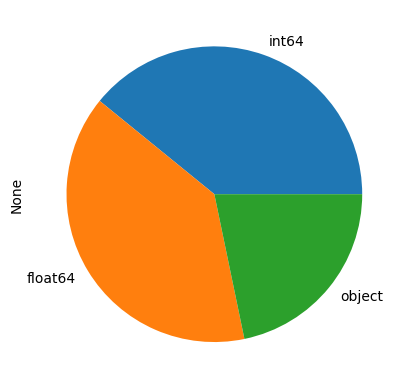

In [13]:
df.dtypes.value_counts().plot.pie()

<AxesSubplot:>

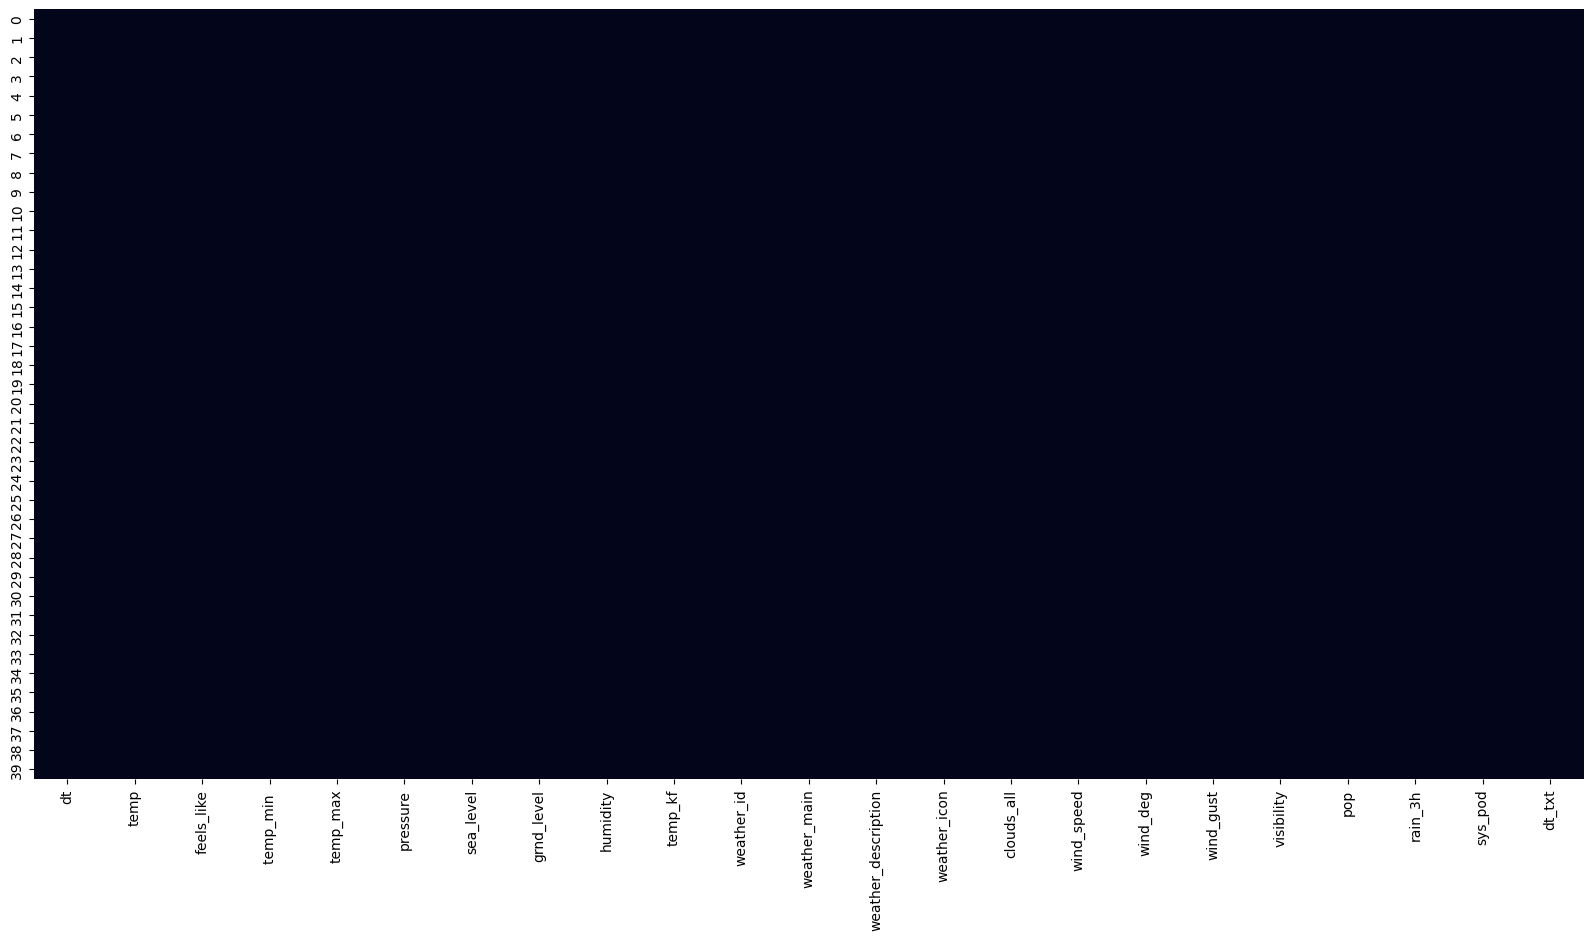

In [14]:
# # Checking missing values
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [15]:
# Checking missing values
df.isnull().sum().sort_values(ascending=False)

dt                     0
weather_description    0
sys_pod                0
rain_3h                0
pop                    0
visibility             0
wind_gust              0
wind_deg               0
wind_speed             0
clouds_all             0
weather_icon           0
weather_main           0
temp                   0
weather_id             0
temp_kf                0
humidity               0
grnd_level             0
sea_level              0
pressure               0
temp_max               0
temp_min               0
feels_like             0
dt_txt                 0
dtype: int64

In [16]:

#classification or reclassification of variables according to type or function:
# view on https://www.kaggle.com/code/ozlemilgun/the-prediction-of-titanic-passengers-survival

def grab_col_names(dataframe, cat_th=5, car_th=20):
    """
    This function to perform the selection of numeric and categorical variables in the data set in a parametric way.
    Note: Variables with numeric data type but with categorical properties are included in categorical variables.

    Parameters
    ----------
    dataframe: dataframe
        The data set in which Variable types need to be parsed
    cat_th: int, optional
        The threshold value for number of distinct observations in numerical variables with categorical properties.
        cat_th is used to specify that if number of distinct observations in numerical variable is less than
        cat_th, this variables can be categorized as a categorical variable.

    car_th: int, optional
        The threshold value for categorical variables with  a wide range of cardinality.
        If the number of distinct observations in a categorical variables is greater than car_th, this
        variable can be categorized as a categorical variable.

    Returns
    -------
        cat_cols: list
            List of categorical variables.
        num_cols: list
            List of numerical variables.
        cat_but_car: list
            List of categorical variables with  a wide range of cardinality.

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    Notes
    ------
        Sum of elements in lists the cat_cols,num_cols  and  cat_but_car give the total number of variables in dataframe.
    """

    # cat cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and
                   dataframe[col].nunique() < cat_th]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and
                   dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and "ID" not in col.upper()]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols,num_cols,cat_but_car


In [17]:
grab_col_names(df)

(['weather_main',
  'weather_description',
  'weather_icon',
  'sys_pod',
  'temp_kf',
  'visibility'],
 ['dt',
  'temp',
  'feels_like',
  'temp_min ',
  'temp_max',
  'pressure',
  'sea_level',
  'grnd_level',
  'clouds_all',
  'wind_speed',
  'wind_deg',
  'wind_gust',
  'pop',
  'rain_3h'],
 ['dt_txt'])

In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [19]:
#checking for duplicated rows and missing values
print(df.duplicated().sum())
print(df.isnull().sum().sum())

0
0


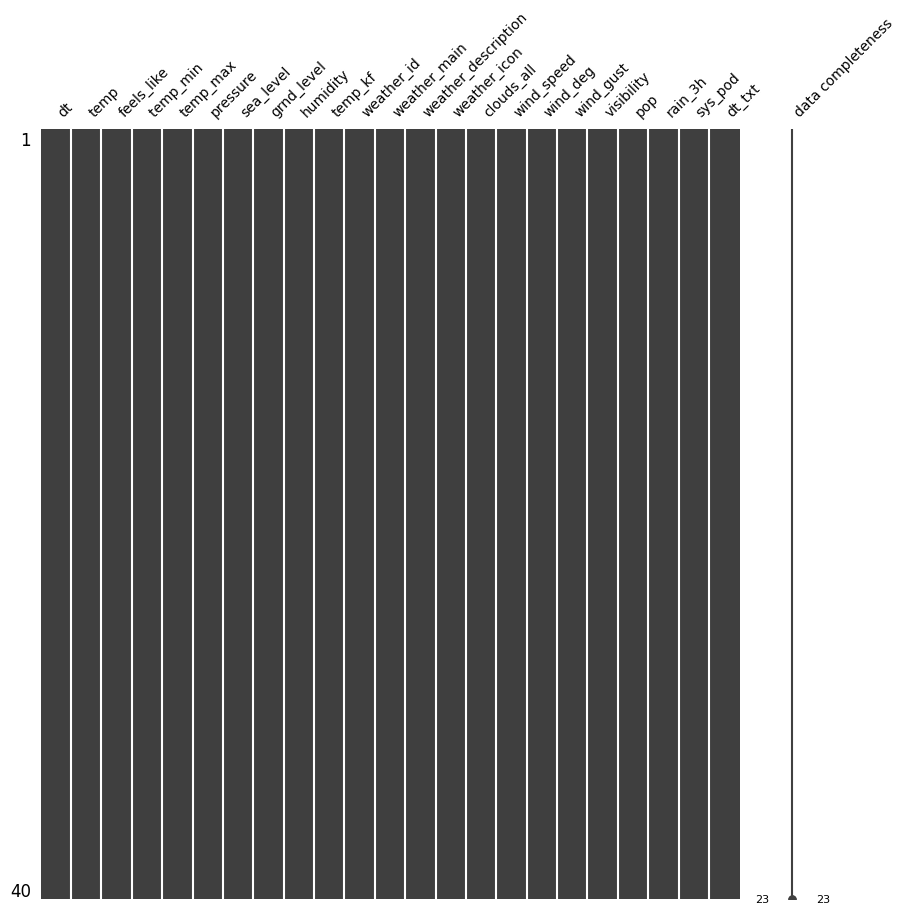

In [20]:
# La matrice de nullité msno.matrix est un affichage dense en données
#qui  permet de repérer rapidement et visuellement des modèles dans l'achèvement des données.
msno.matrix(df, figsize=(10,10), fontsize=10, labels=8)
plt.show()

In [21]:
# Printing unique values in data
for col in df.columns:
  print(f'{col :-<30} {df[col].unique()}')
    #print('unique values in "{}":\n'.format(i),df[i].unique())

dt---------------------------- [1694444400 1694455200 1694466000 1694476800 1694487600 1694498400
 1694509200 1694520000 1694530800 1694541600 1694552400 1694563200
 1694574000 1694584800 1694595600 1694606400 1694617200 1694628000
 1694638800 1694649600 1694660400 1694671200 1694682000 1694692800
 1694703600 1694714400 1694725200 1694736000 1694746800 1694757600
 1694768400 1694779200 1694790000 1694800800 1694811600 1694822400
 1694833200 1694844000 1694854800 1694865600]
temp-------------------------- [30.54 29.66 28.61 28.33 25.88 24.04 25.55 26.66 27.11 27.59 27.54 27.42
 27.17 27.05 27.41 27.83 28.04 28.03 27.93 27.8  27.66 27.62 27.71 28.19
 27.9  27.81 27.75 27.69 27.44 27.29 27.96 27.97 27.78 27.58 27.38 27.14
 27.01 27.34]
feels_like-------------------- [37.52 34.68 32.93 32.43 26.82 24.85 26.33 26.66 29.5  30.6  30.61 30.46
 29.92 29.66 30.33 30.98 31.44 31.57 31.63 31.46 31.27 30.91 31.12 31.78
 31.28 31.08 30.81 30.69 30.28 30.07 30.66 30.99 30.87 30.62 30.04 29.65
 29.48 

In [62]:
# suppression des variables inutiles
df.drop(columns=["dt_txt","weather_icon","weather_id","dt"], inplace=True)

In [28]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [29]:

# creating report
report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)


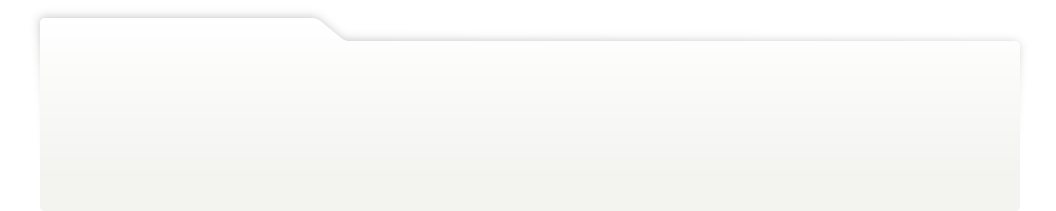
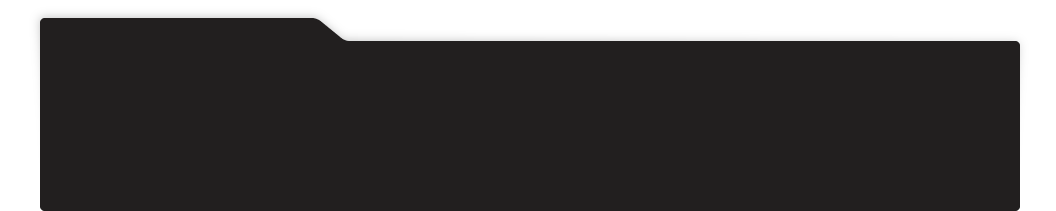
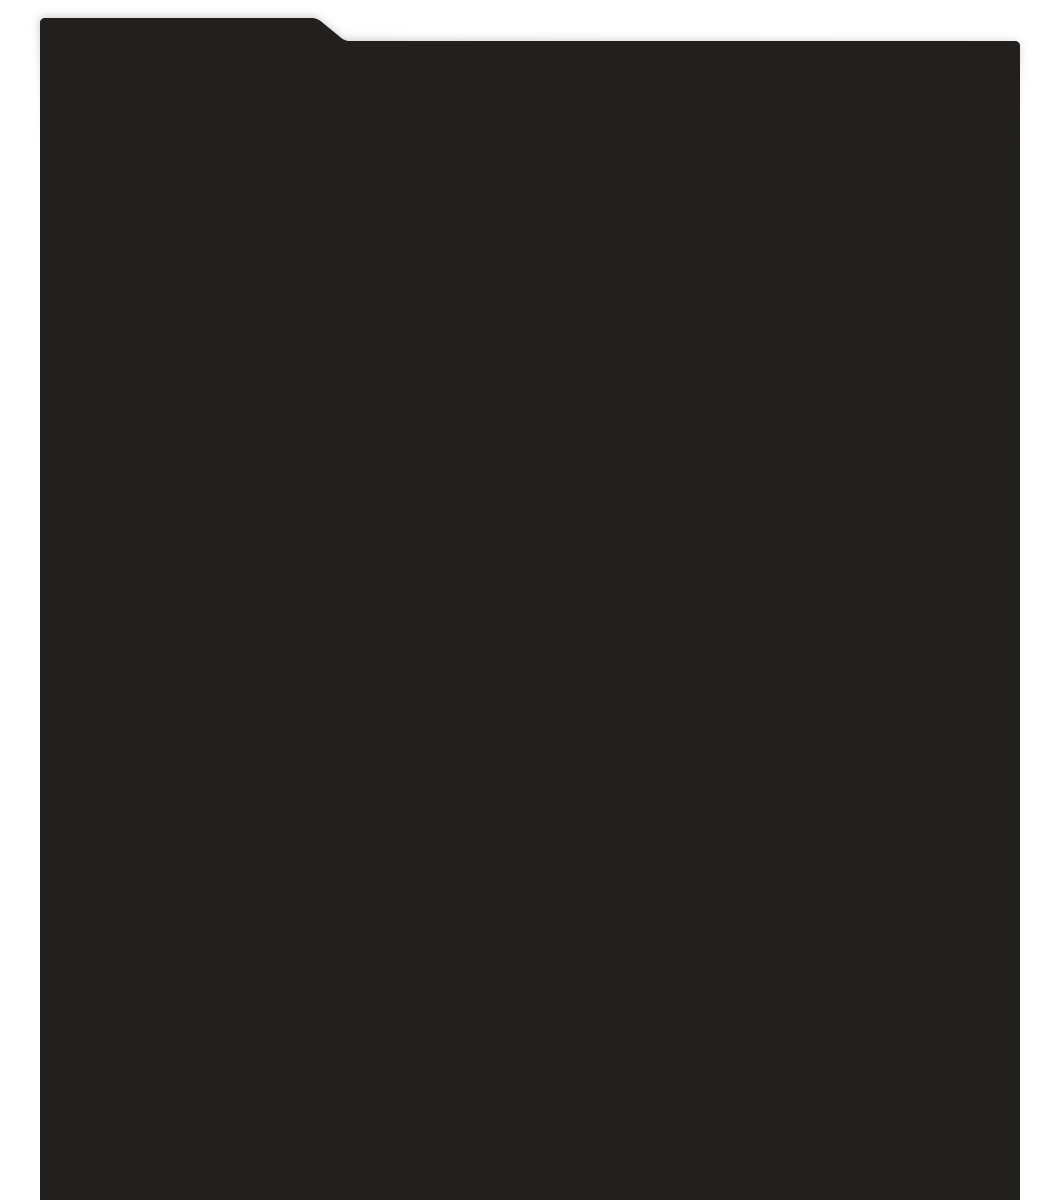
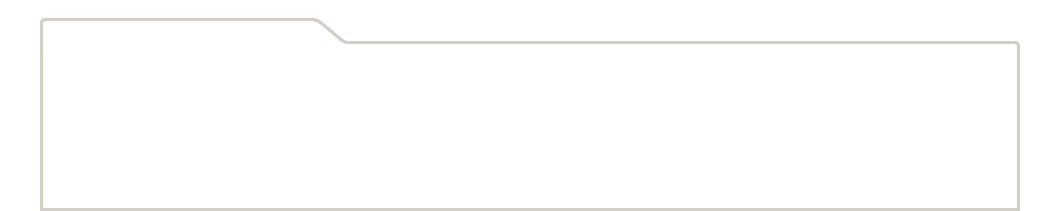
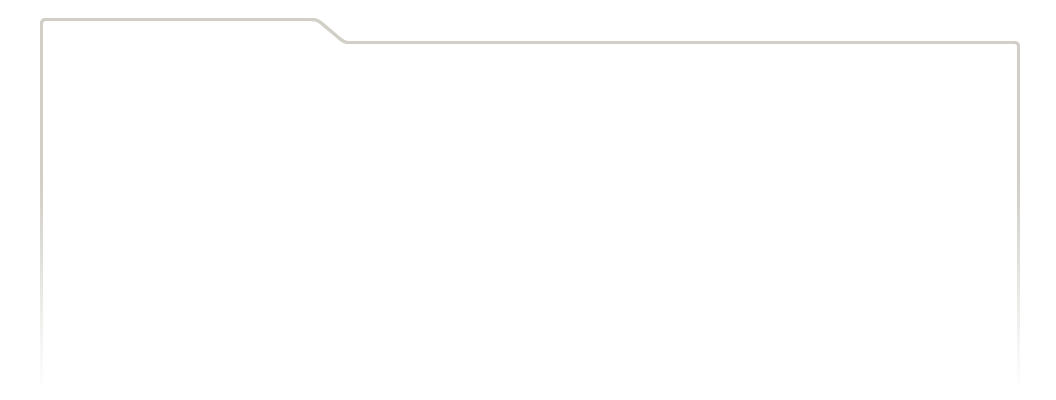
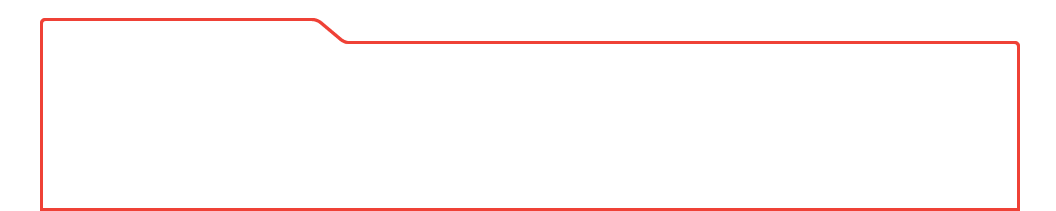
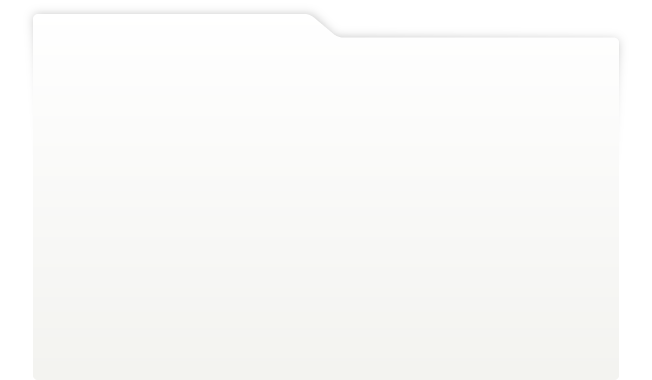
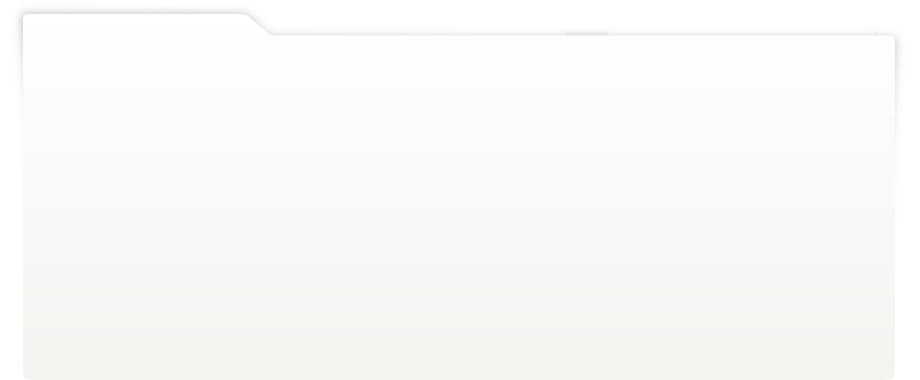
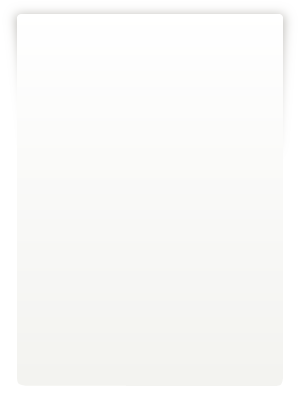
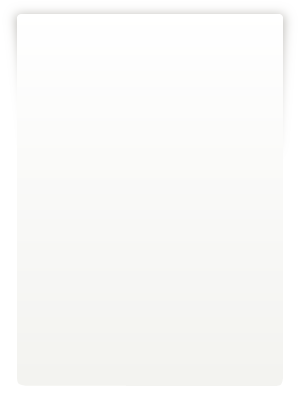
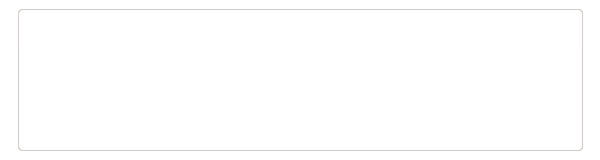
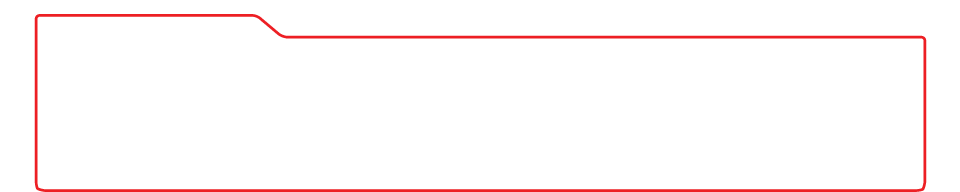
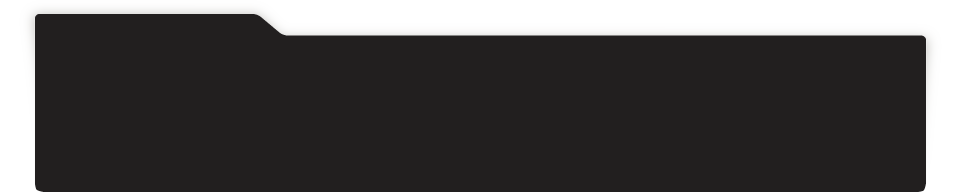
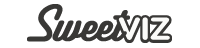
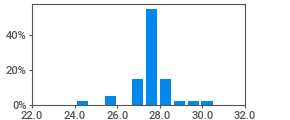
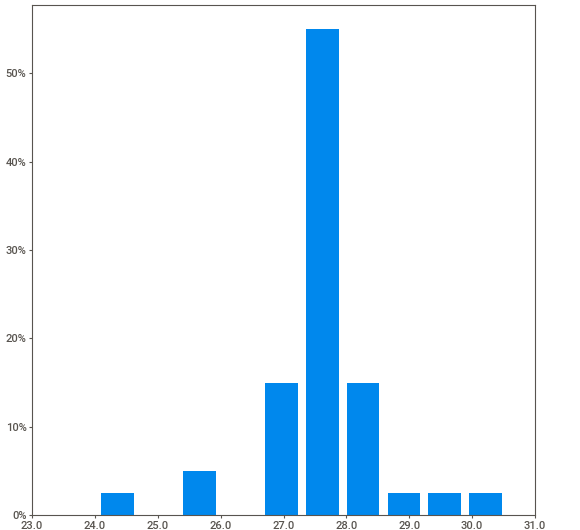
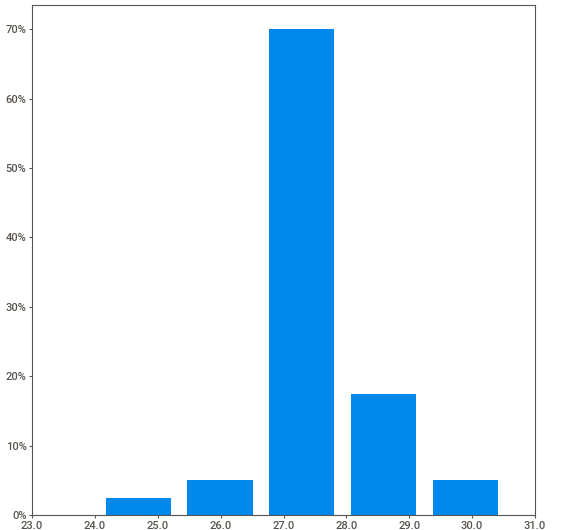
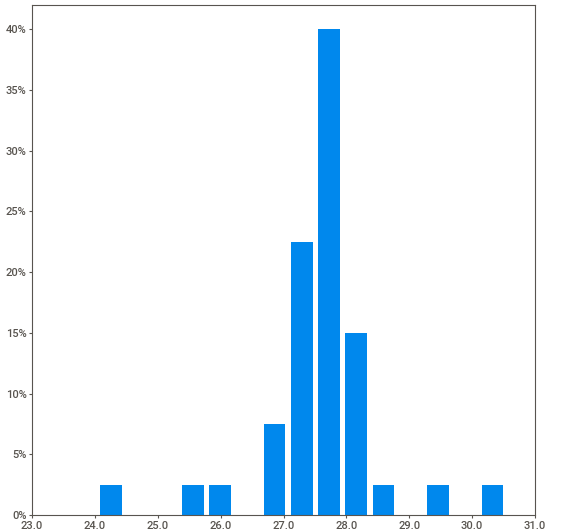
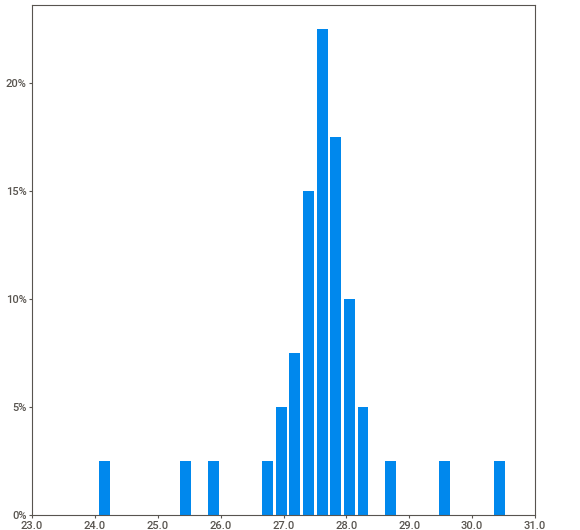
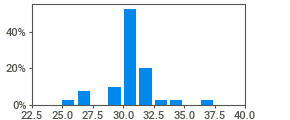
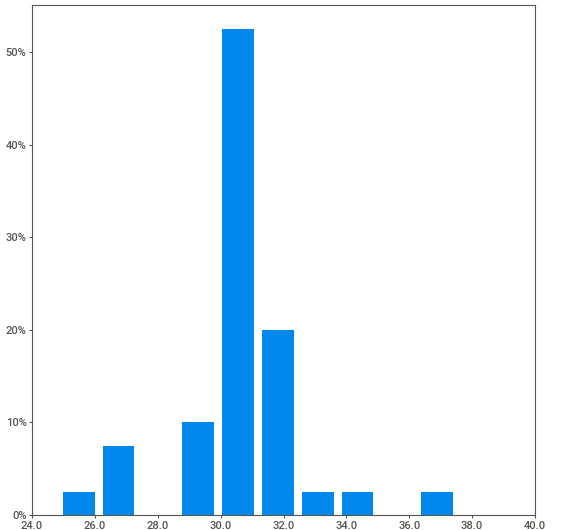
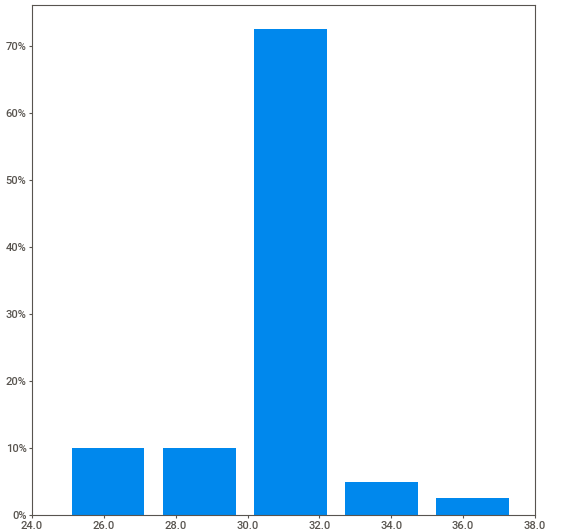
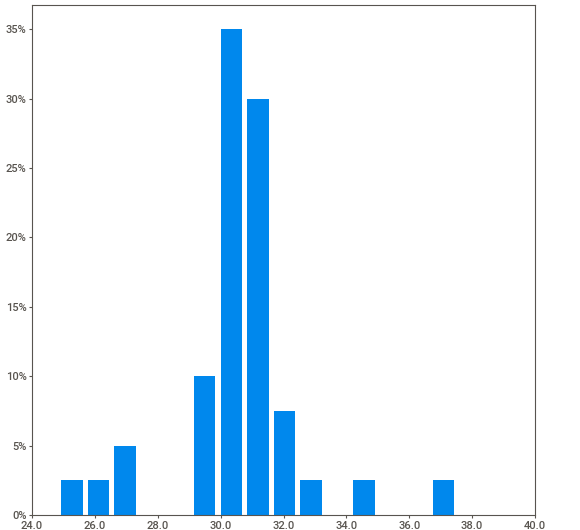
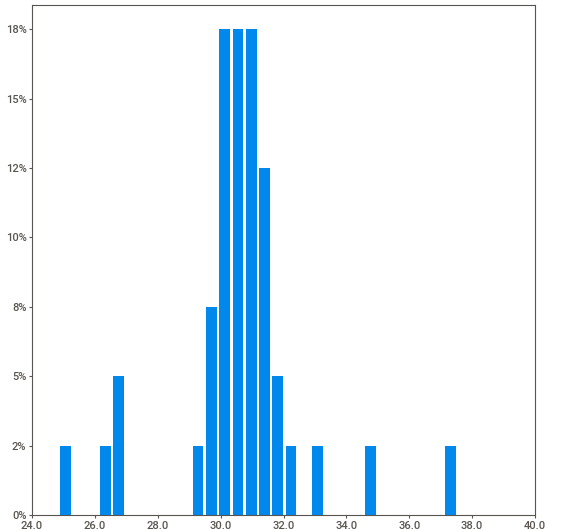
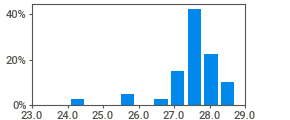
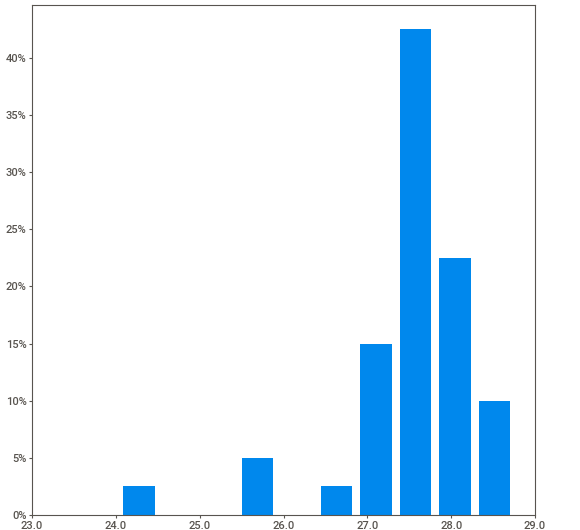
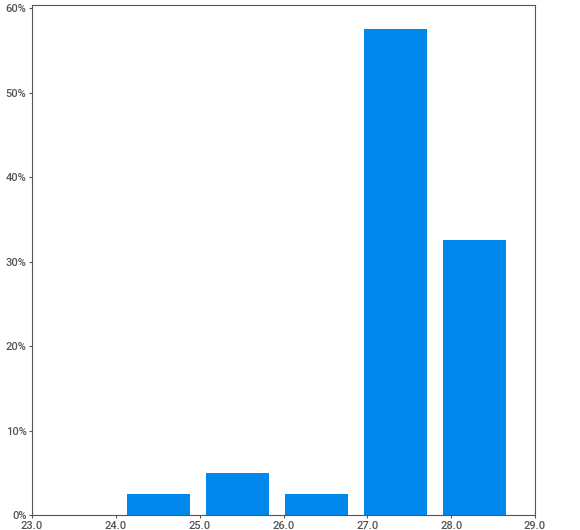
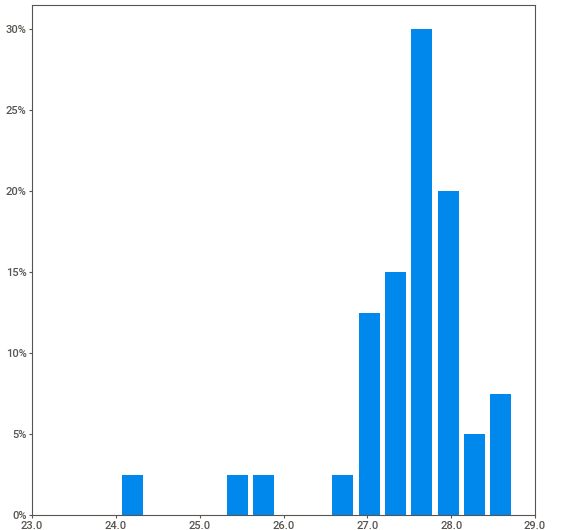
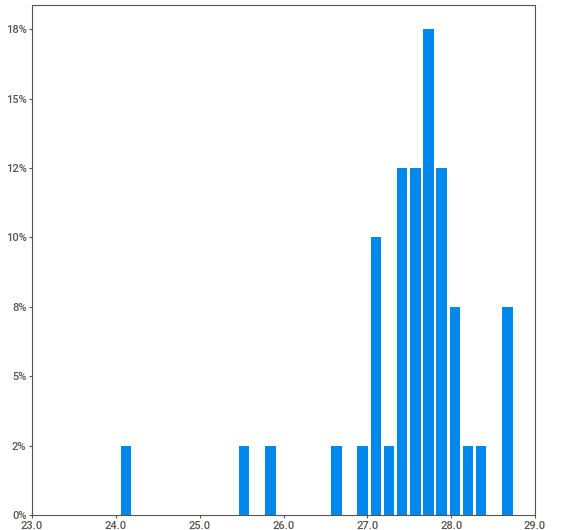
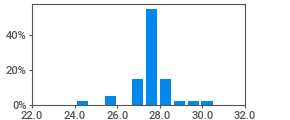
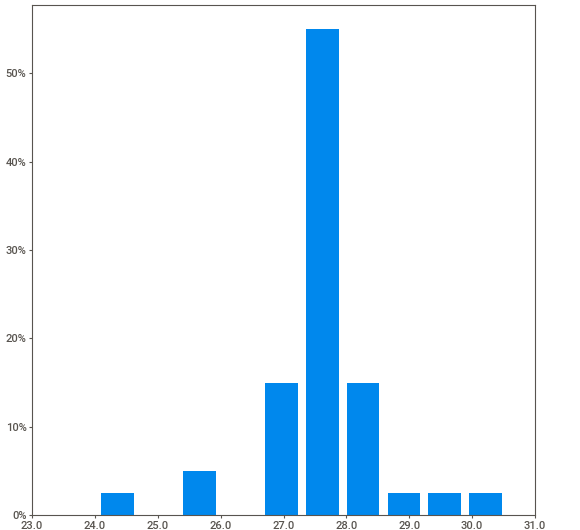
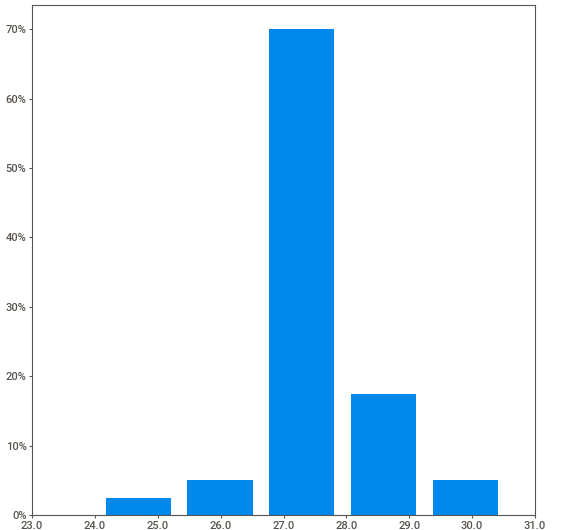
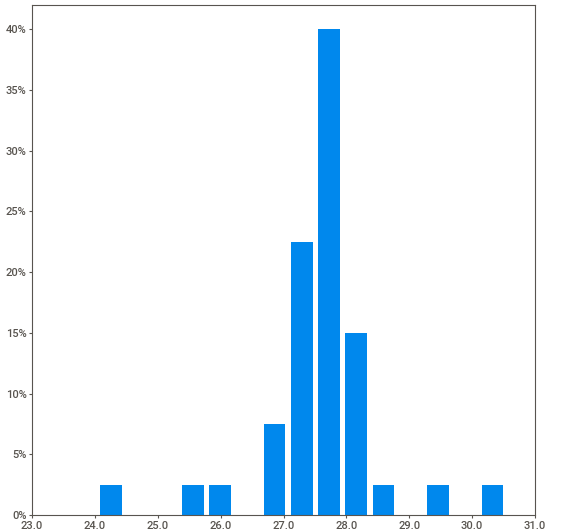
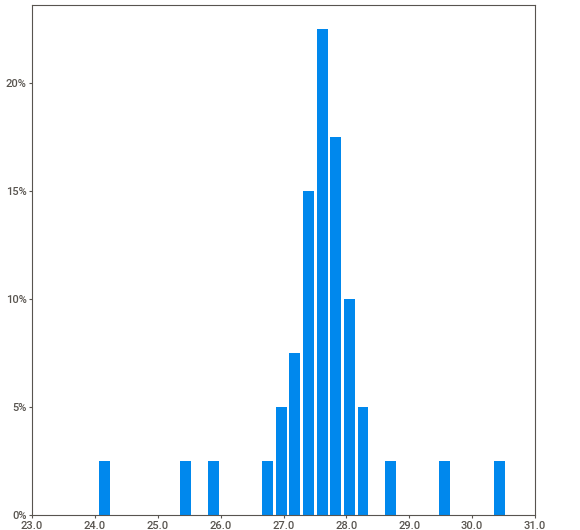
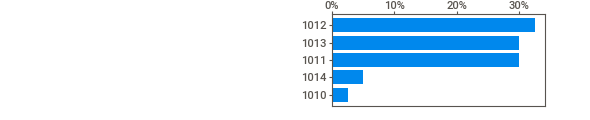
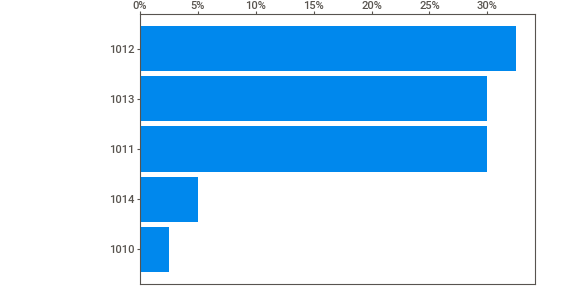
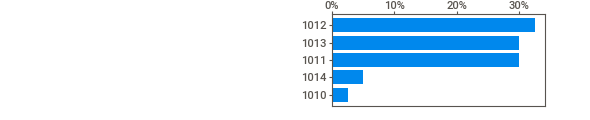
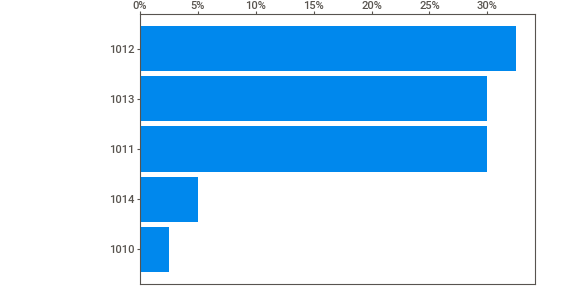
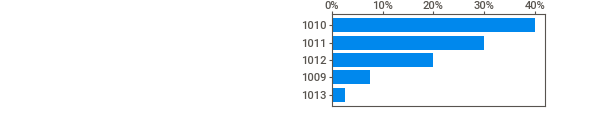
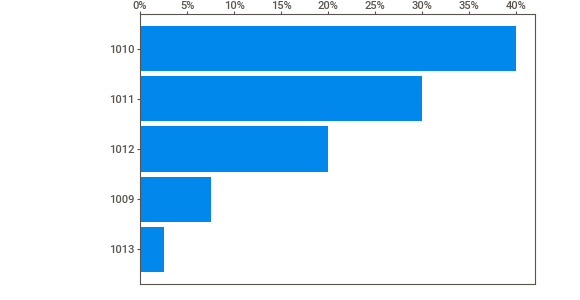
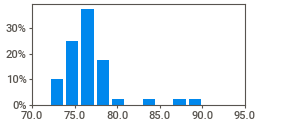
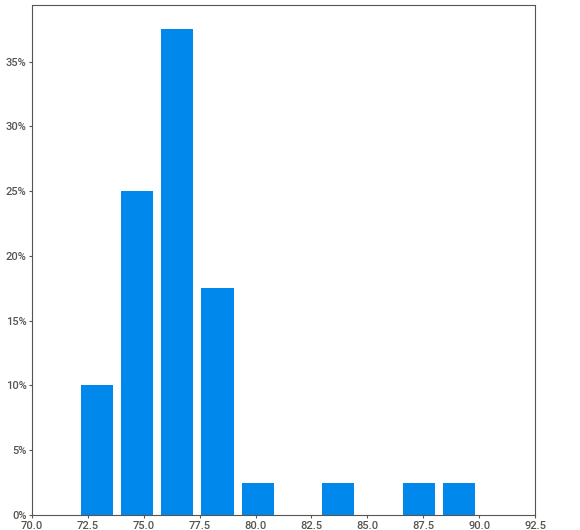
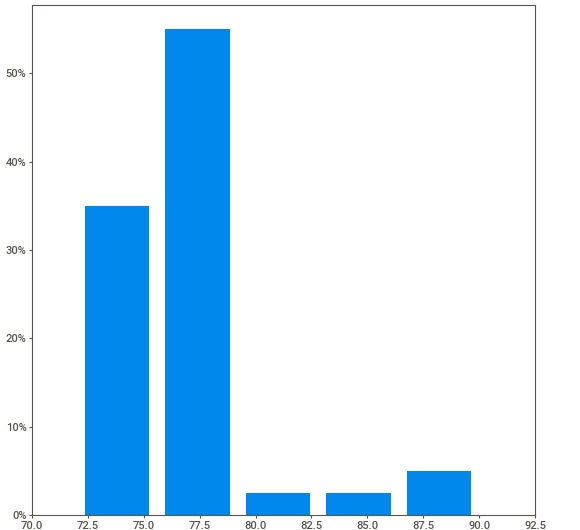
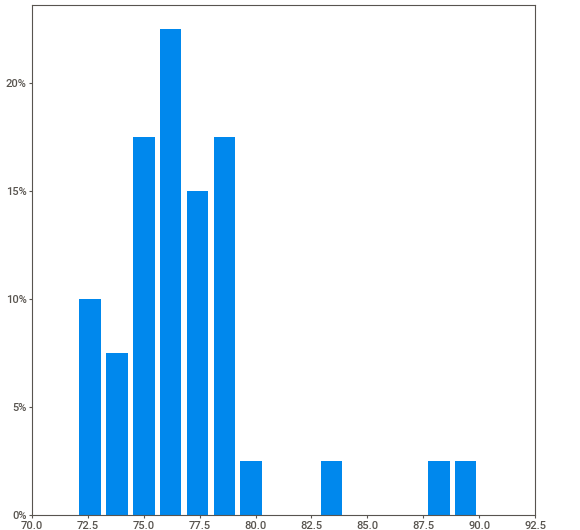
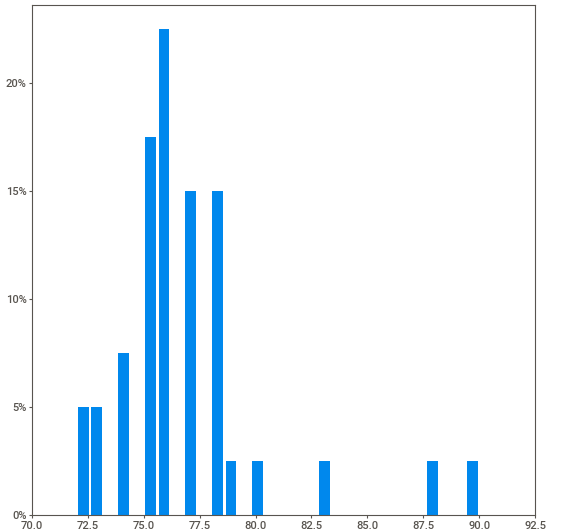
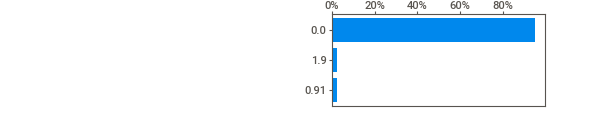
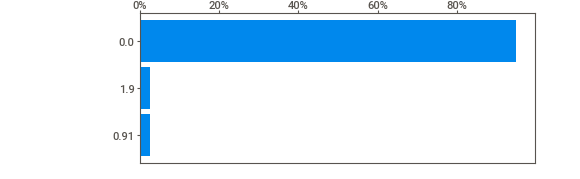
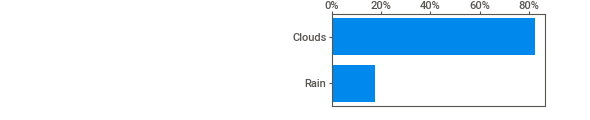
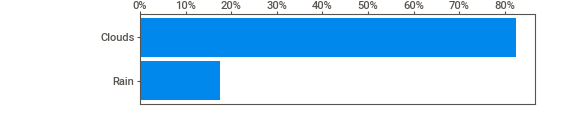
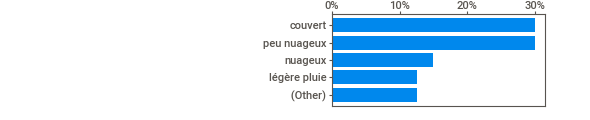
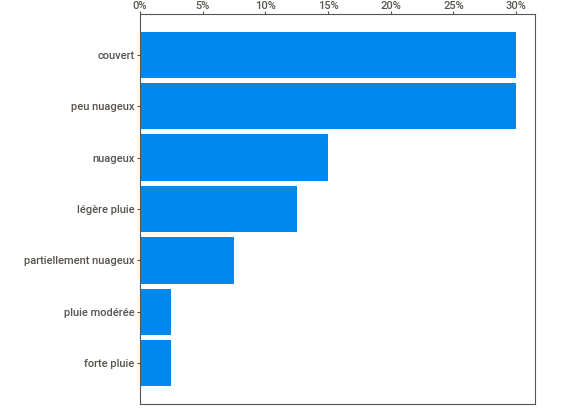
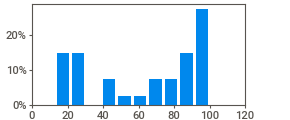
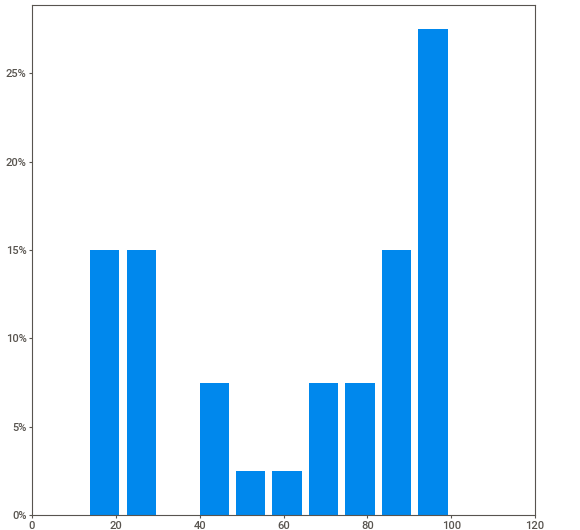
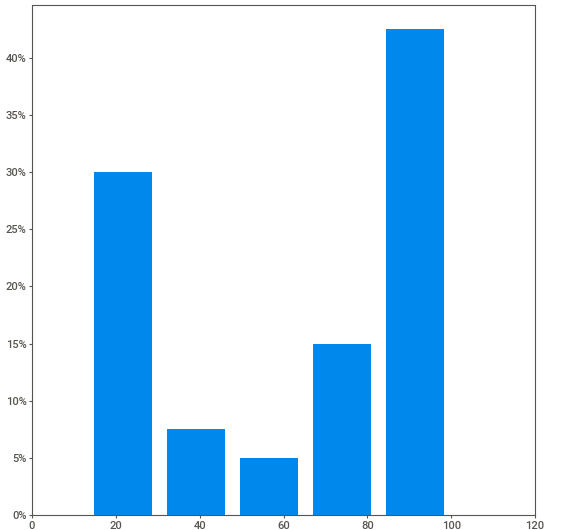
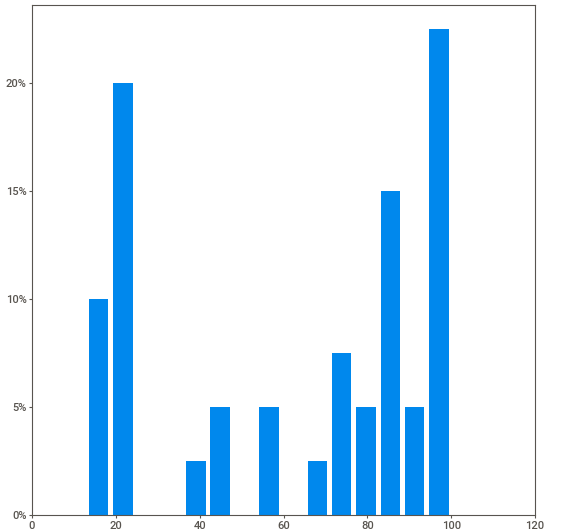
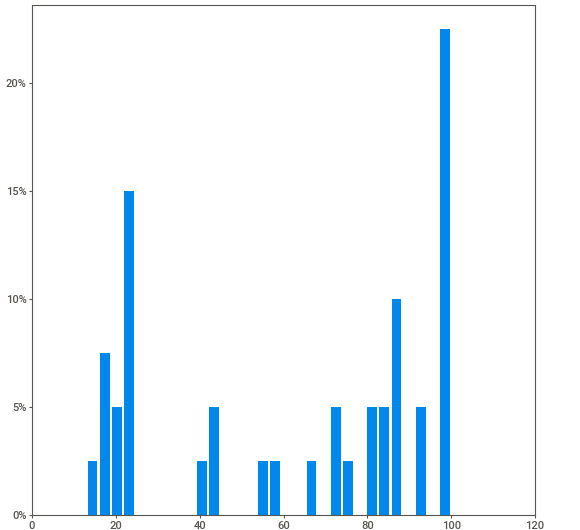
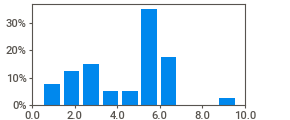
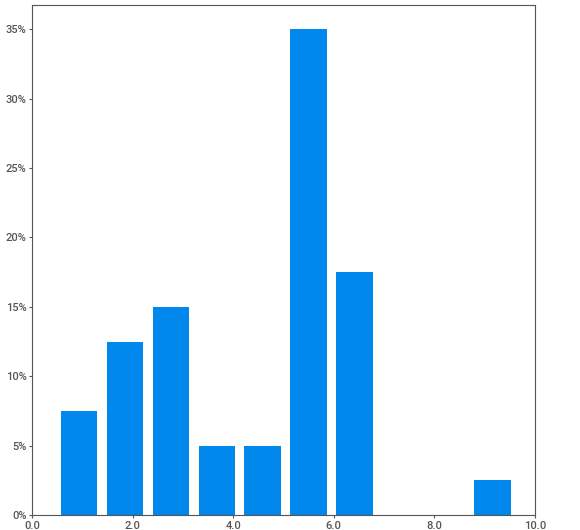
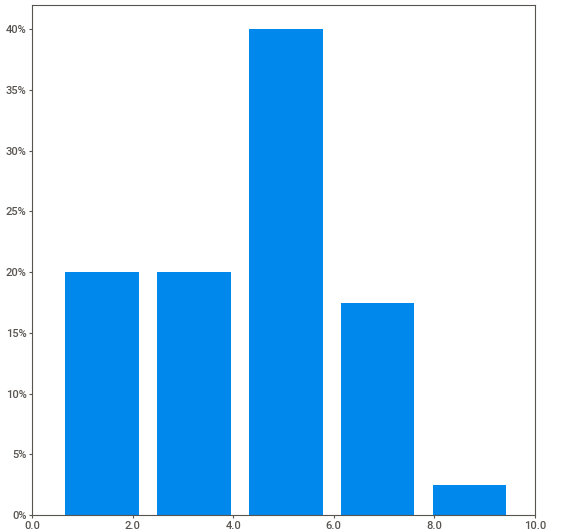
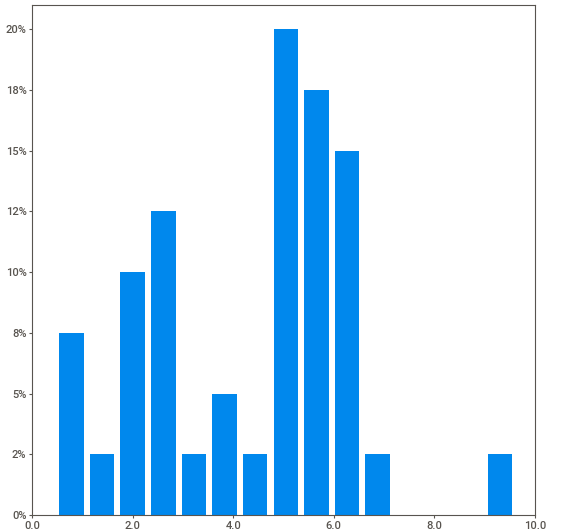
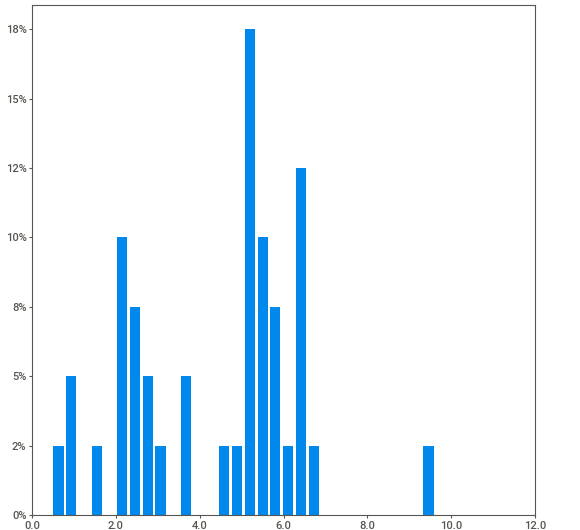
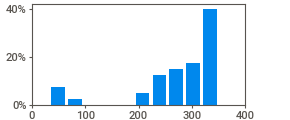
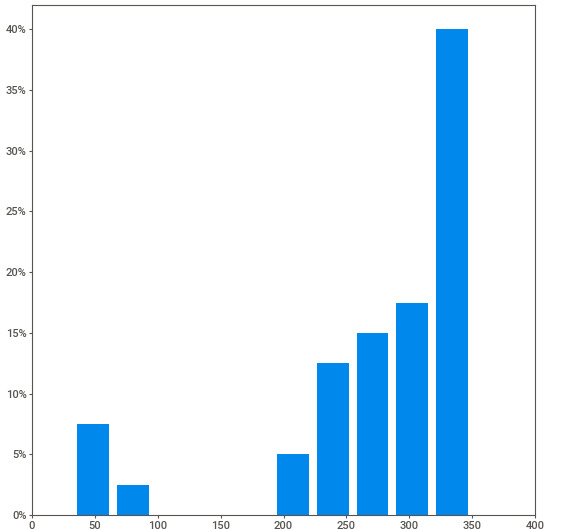
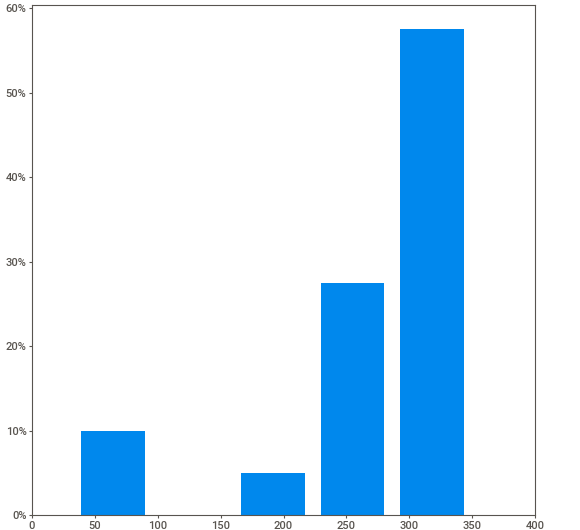
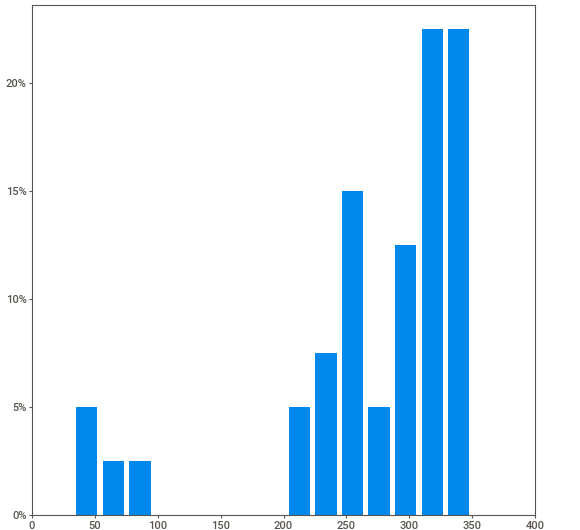
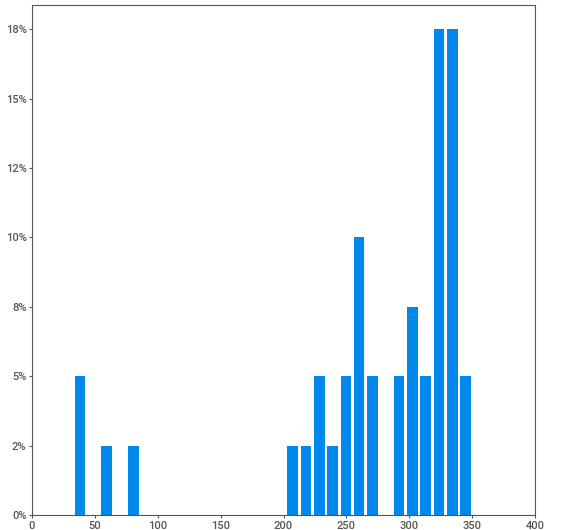
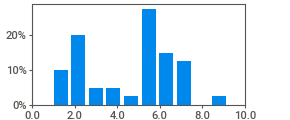
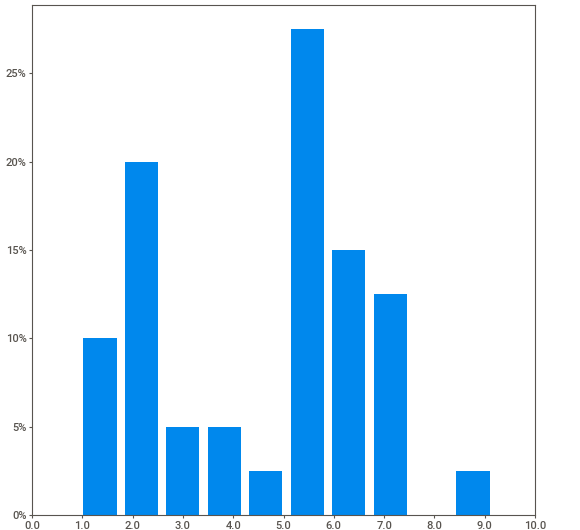
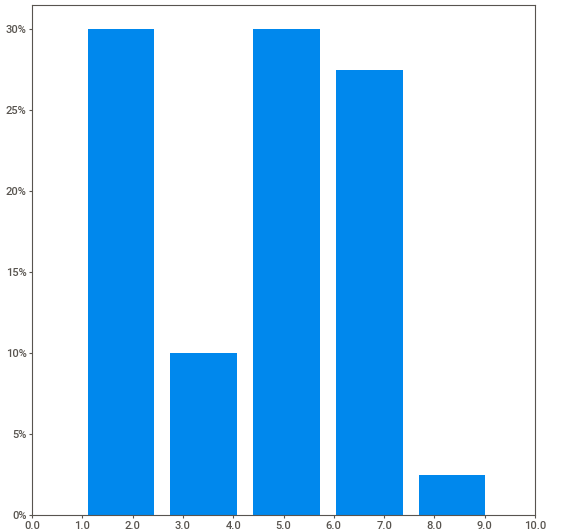
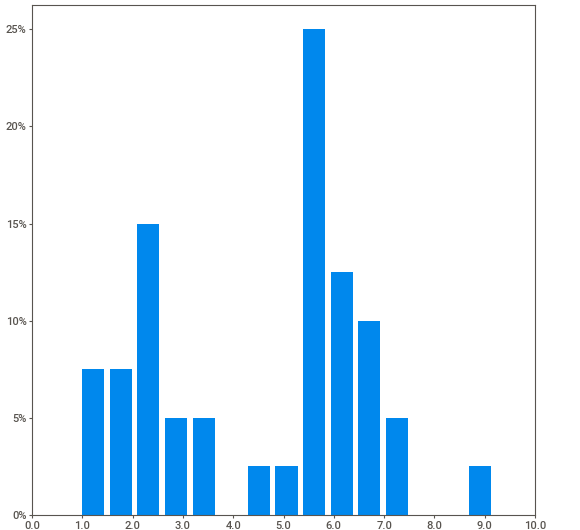
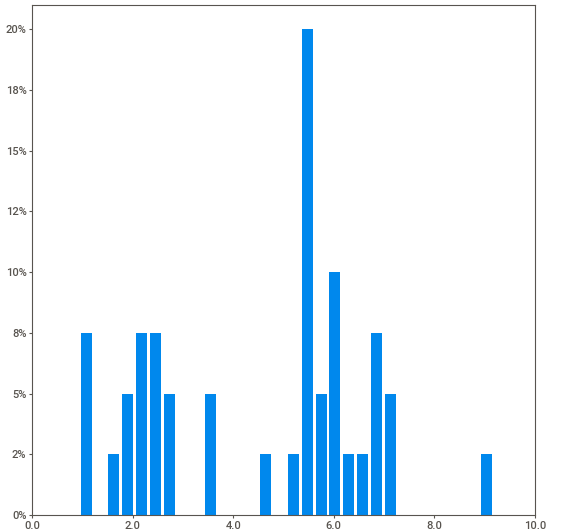
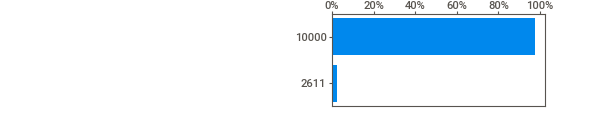
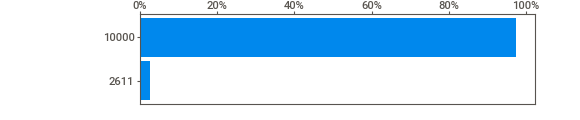
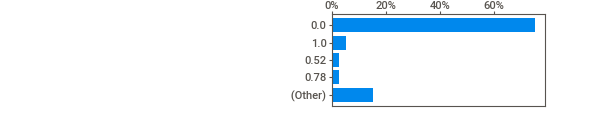
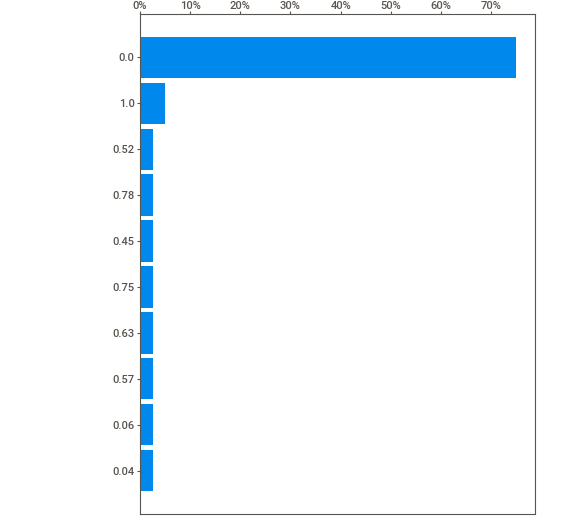
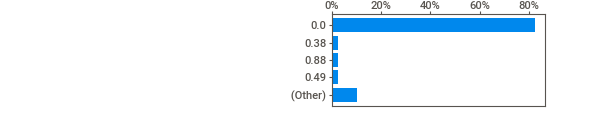
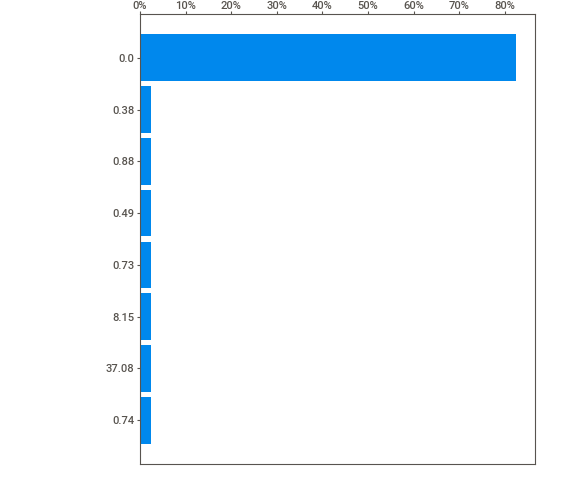
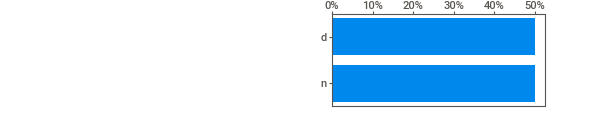
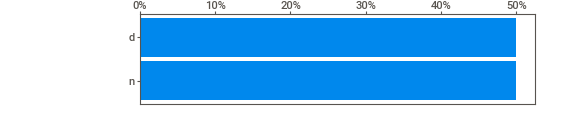
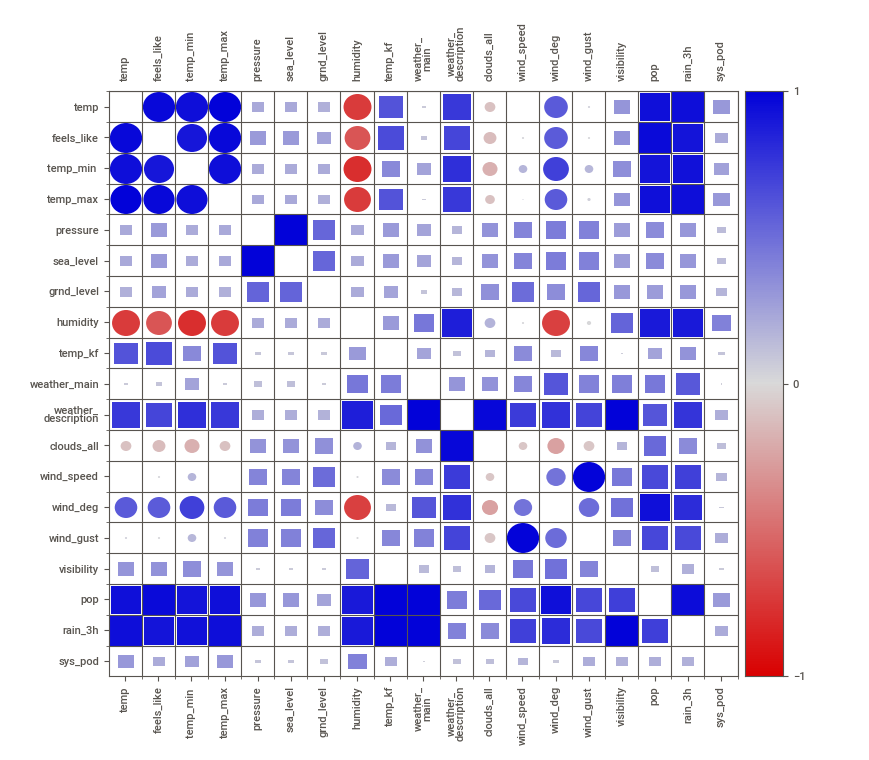
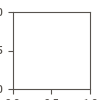

In [30]:
#Visualizing the notebook
report.show_notebook()

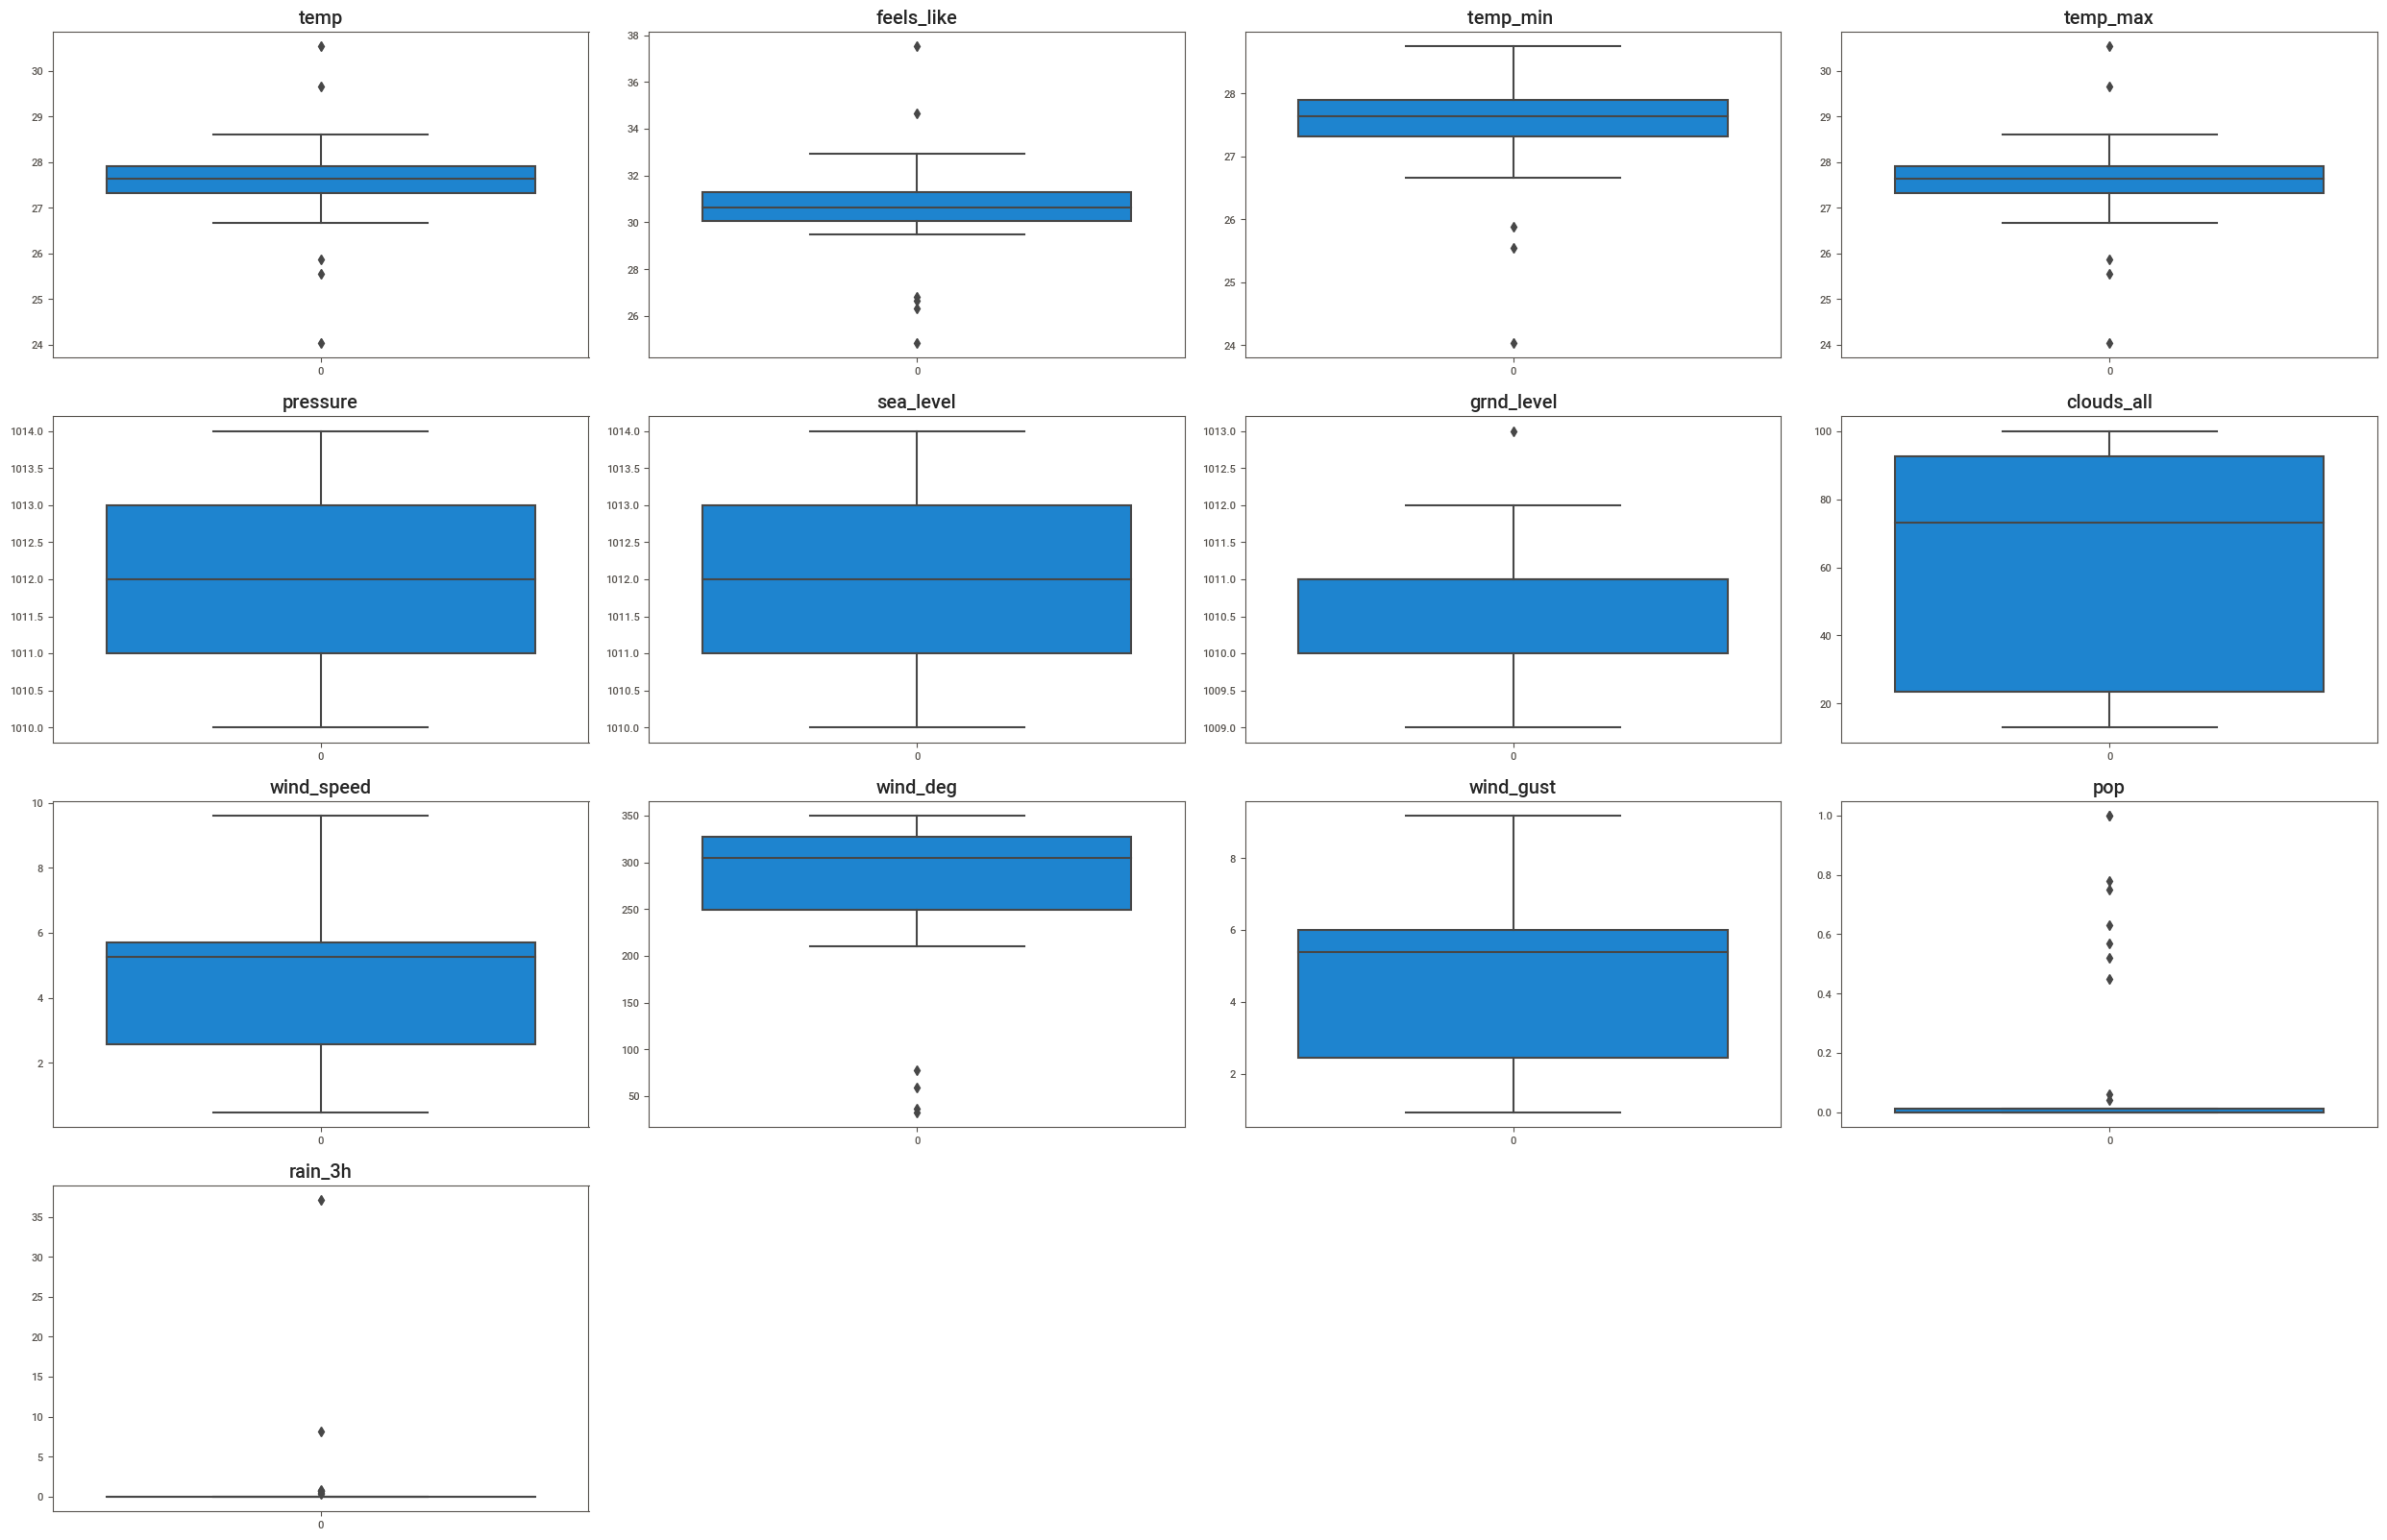

In [31]:
# plot for outliers detection

plt.figure(figsize=(25,20))
for i in range(len(num_cols)):
    plt.subplot(5,4,i+1)
    sns.boxplot(df[num_cols[i]])
    plt.title(num_cols[i])

plt.tight_layout()

############## Unique Observations of Categorical Data ###############
The unique number of weather_main: 2
############## Frequency of Categorical Data ########################
        weather_main  Ratio
Clouds            33  0.825
Rain               7  0.175


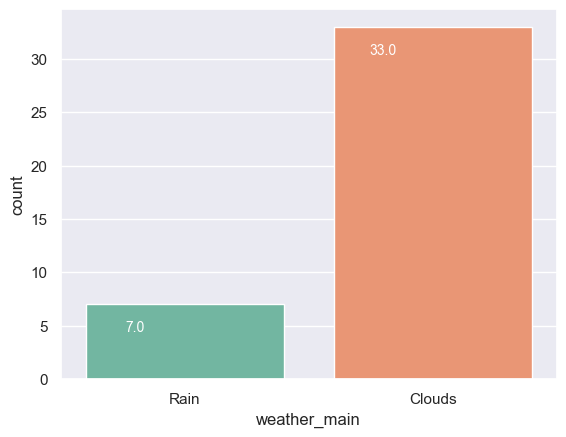

############## Unique Observations of Categorical Data ###############
The unique number of weather_description: 7
############## Frequency of Categorical Data ########################
                       weather_description  Ratio
couvert                                 12  0.300
peu nuageux                             12  0.300
nuageux                                  6  0.150
légère pluie                             5  0.125
partiellement nuageux                    3  0.075
pluie modérée                            1  0.025
forte pluie                              1  0.025


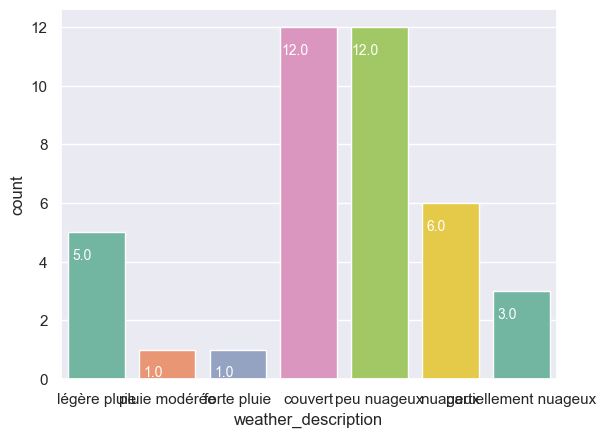

############## Unique Observations of Categorical Data ###############
The unique number of sys_pod: 2
############## Frequency of Categorical Data ########################
   sys_pod  Ratio
d       20    0.5
n       20    0.5


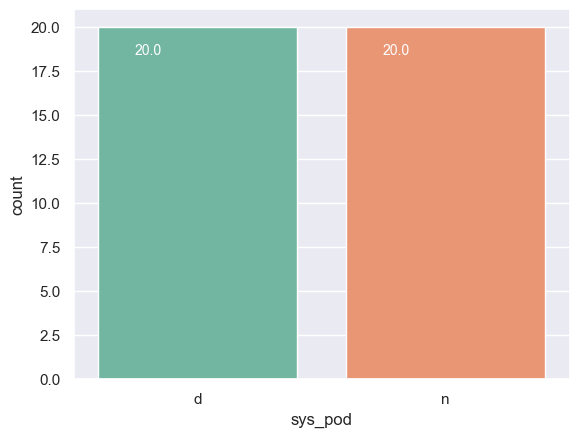

############## Unique Observations of Categorical Data ###############
The unique number of temp_kf: 3
############## Frequency of Categorical Data ########################
      temp_kf  Ratio
0.00       38  0.950
1.90        1  0.025
0.91        1  0.025


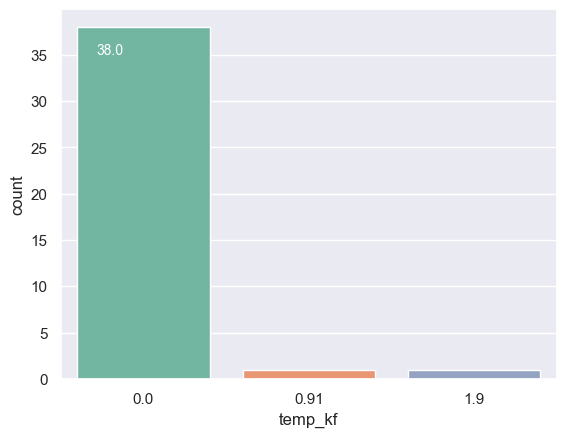

############## Unique Observations of Categorical Data ###############
The unique number of visibility: 2
############## Frequency of Categorical Data ########################
       visibility  Ratio
10000          39  0.975
2611            1  0.025


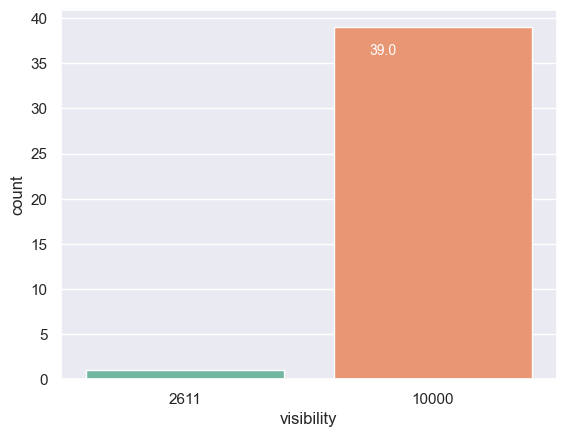

In [32]:
 # General Exploration for Categorical Variables:

def cat_summary(dataframe, plot=False):
    for col_name in cat_cols:
        print("############## Unique Observations of Categorical Data ###############")
        print("The unique number of "+ col_name+": "+ str(dataframe[col_name].nunique()))

        print("############## Frequency of Categorical Data ########################")
        print(pd.DataFrame({col_name : dataframe[col_name].value_counts(),
                            "Ratio": dataframe[col_name].value_counts()/len(dataframe)}))
        if plot == True:
            rgb_values = sns.color_palette("Set2", 6)
            sns.set_theme(style="darkgrid")
            ax = sns.countplot(x=dataframe[col_name], data=dataframe, palette=rgb_values)
            for p in ax.patches:
                ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=10)
            plt.show()

cat_summary(df, plot=True)

########## Summary Statistics of temp ############
count    40.000000
mean     27.568000
std       0.988802
min      24.040000
25%      27.327500
50%      27.640000
75%      27.907500
100%     30.540000
max      30.540000
Name: temp, dtype: float64


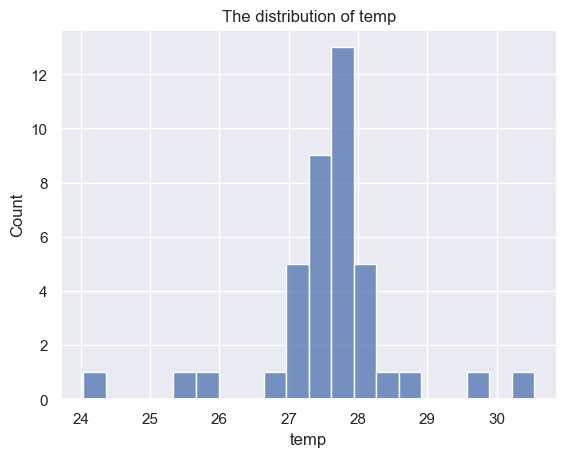

########## Summary Statistics of feels_like ############
count    40.000000
mean     30.573500
std       2.069441
min      24.850000
25%      30.062500
50%      30.640000
75%      31.272500
100%     37.520000
max      37.520000
Name: feels_like, dtype: float64


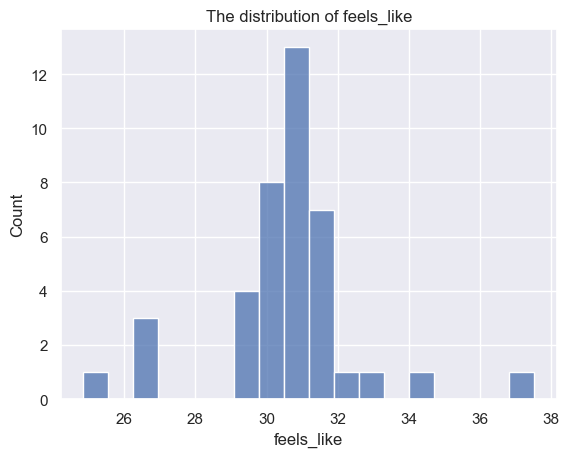

########## Summary Statistics of temp_min  ############
count    40.000000
mean     27.497750
std       0.836217
min      24.040000
25%      27.327500
50%      27.640000
75%      27.907500
100%     28.750000
max      28.750000
Name: temp_min , dtype: float64


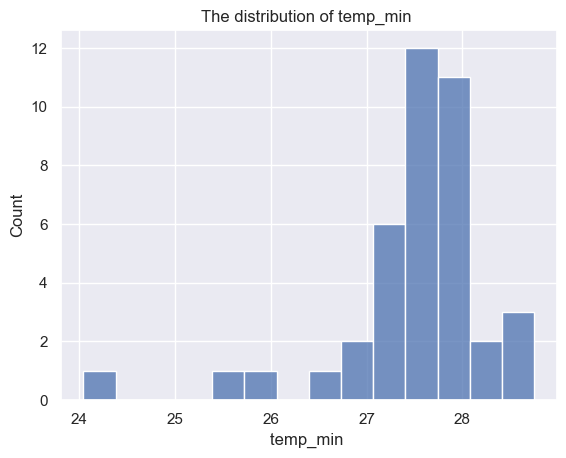

########## Summary Statistics of temp_max ############
count    40.000000
mean     27.568000
std       0.988802
min      24.040000
25%      27.327500
50%      27.640000
75%      27.907500
100%     30.540000
max      30.540000
Name: temp_max, dtype: float64


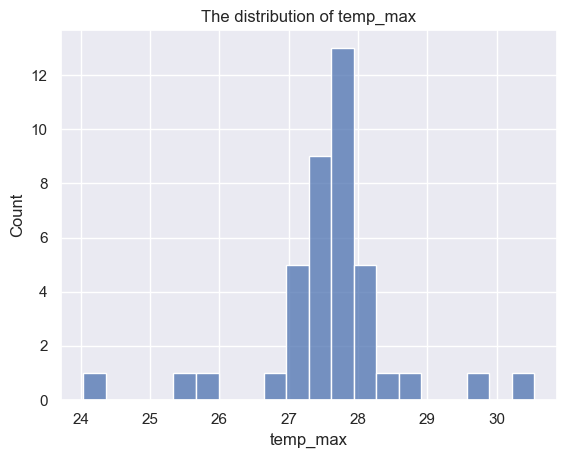

########## Summary Statistics of pressure ############
count      40.000000
mean     1012.050000
std         0.959434
min      1010.000000
25%      1011.000000
50%      1012.000000
75%      1013.000000
100%     1014.000000
max      1014.000000
Name: pressure, dtype: float64


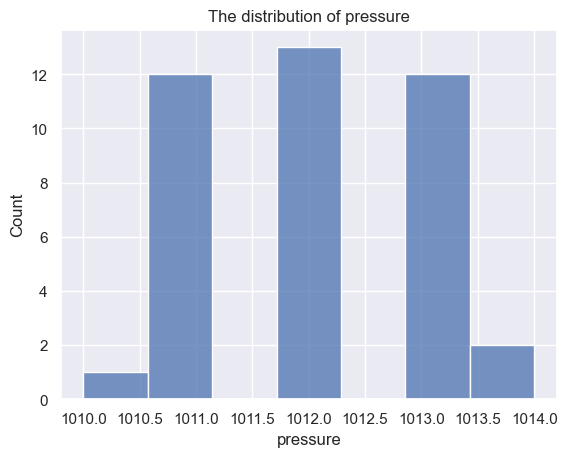

########## Summary Statistics of sea_level ############
count      40.000000
mean     1012.050000
std         0.959434
min      1010.000000
25%      1011.000000
50%      1012.000000
75%      1013.000000
100%     1014.000000
max      1014.000000
Name: sea_level, dtype: float64


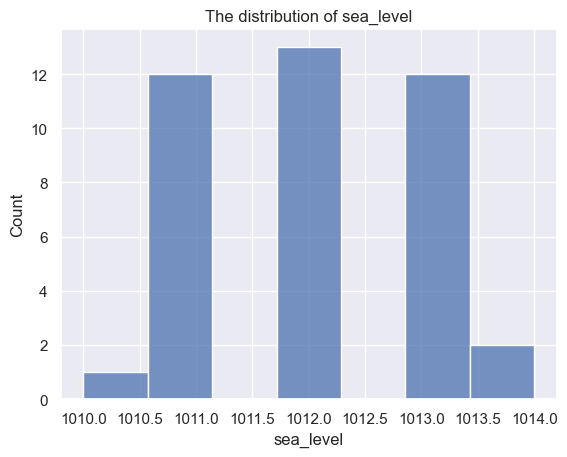

########## Summary Statistics of grnd_level ############
count      40.000000
mean     1010.700000
std         0.966092
min      1009.000000
25%      1010.000000
50%      1011.000000
75%      1011.000000
100%     1013.000000
max      1013.000000
Name: grnd_level, dtype: float64


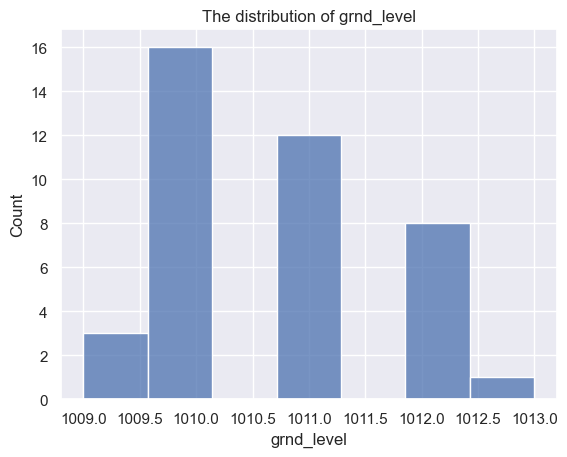

########## Summary Statistics of clouds_all ############
count     40.000000
mean      62.950000
std       32.672383
min       13.000000
25%       23.500000
50%       73.000000
75%       92.500000
100%     100.000000
max      100.000000
Name: clouds_all, dtype: float64


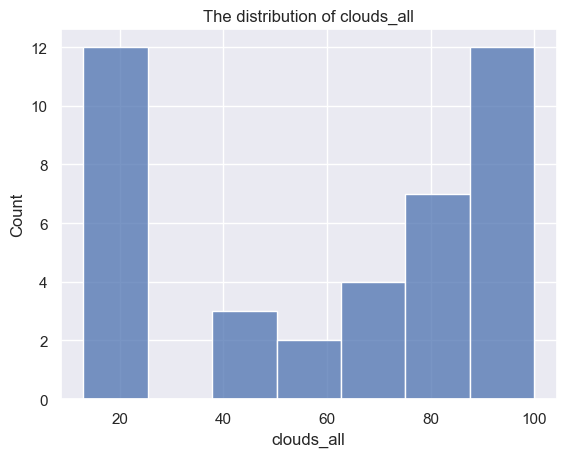

########## Summary Statistics of wind_speed ############
count    40.000000
mean      4.400750
std       2.019048
min       0.480000
25%       2.552500
50%       5.250000
75%       5.715000
100%      9.610000
max       9.610000
Name: wind_speed, dtype: float64


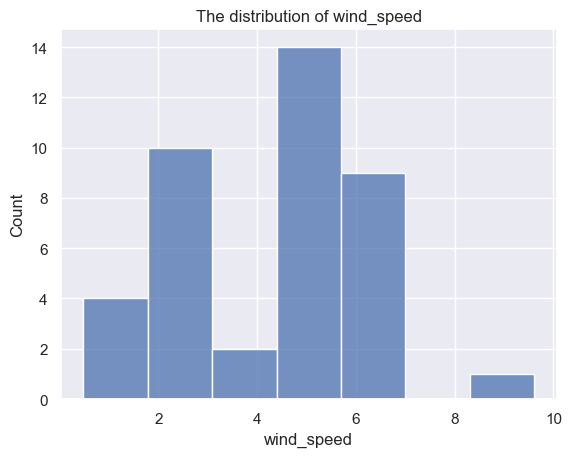

########## Summary Statistics of wind_deg ############
count     40.000000
mean     270.950000
std       83.821223
min       33.000000
25%      249.500000
50%      305.000000
75%      327.250000
100%     350.000000
max      350.000000
Name: wind_deg, dtype: float64


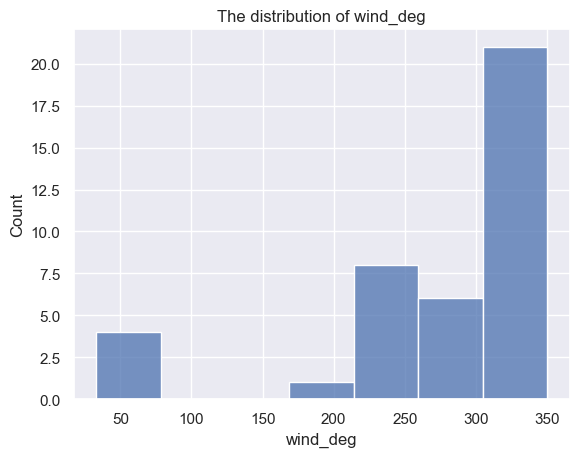

########## Summary Statistics of wind_gust ############
count    40.000000
mean      4.534750
std       2.099348
min       0.940000
25%       2.452500
50%       5.390000
75%       6.000000
100%      9.180000
max       9.180000
Name: wind_gust, dtype: float64


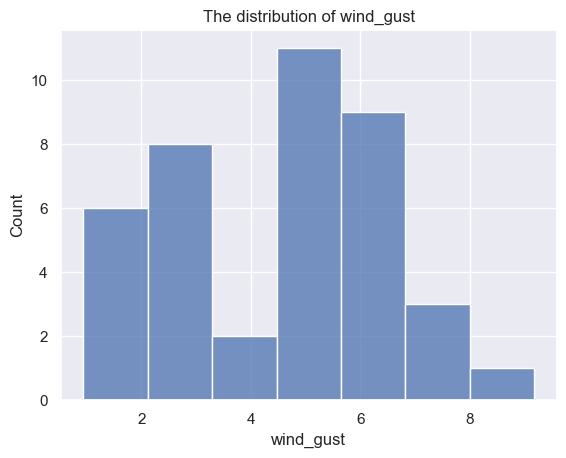

########## Summary Statistics of pop ############
count    40.000000
mean      0.145000
std       0.300845
min       0.000000
25%       0.000000
50%       0.000000
75%       0.010000
100%      1.000000
max       1.000000
Name: pop, dtype: float64


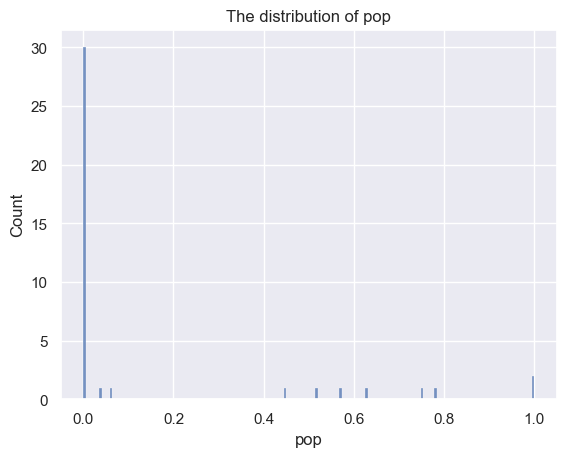

########## Summary Statistics of rain_3h ############
count    40.000000
mean      1.211250
std       5.959055
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
100%     37.080000
max      37.080000
Name: rain_3h, dtype: float64


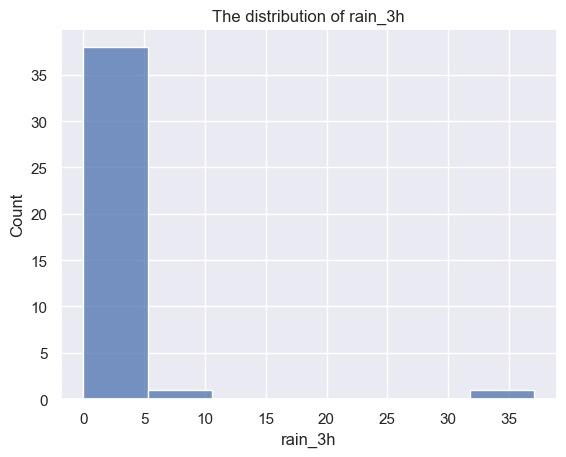

In [33]:
# General Exploration for Numerical Variables:

def num_summary(dataframe,  plot=False):
    quantiles = [0.25, 0.50, 0.75, 1]
    for col_name in num_cols:
        print("########## Summary Statistics of " +  col_name + " ############")
        print(dataframe[col_name].describe(quantiles).T)

        if plot:
            sns.histplot(data=dataframe, x=col_name  )
            plt.xlabel(col_name)
            plt.title("The distribution of "+ col_name)
            plt.grid(True)
            plt.show(block=True)

num_summary(df, plot=True)

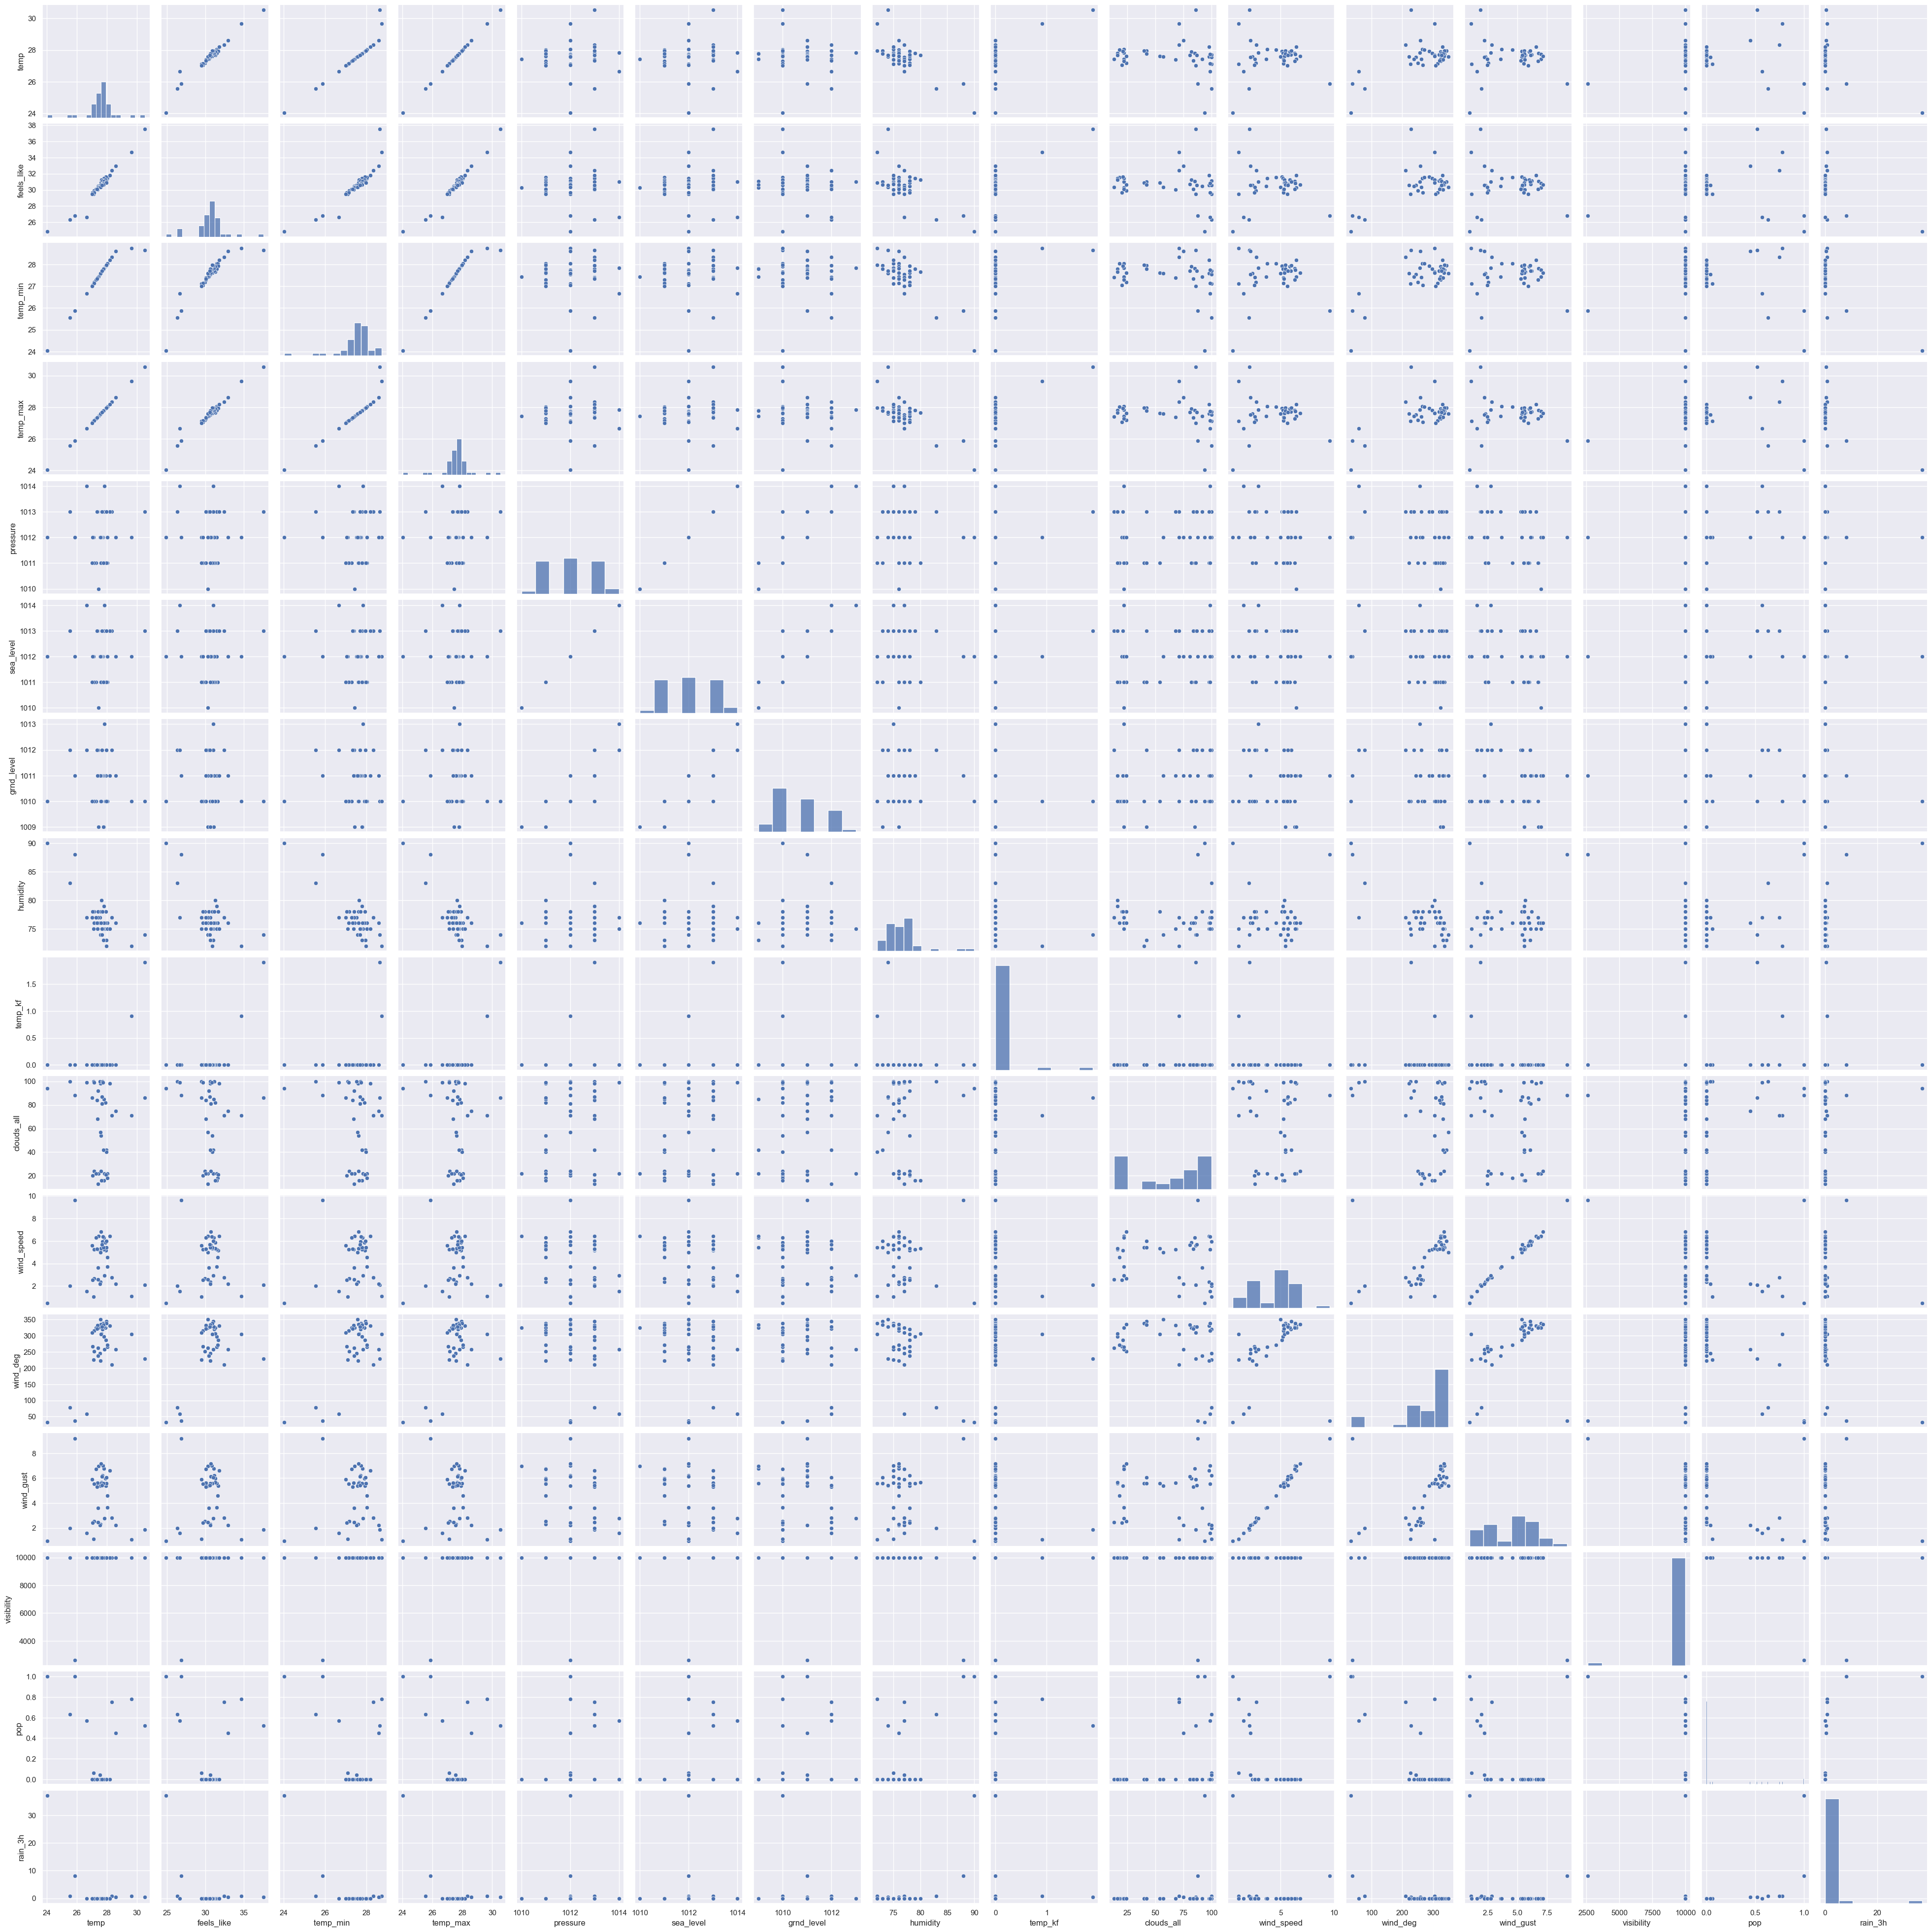

In [34]:
#Relation Variables / Variables
#sns.pairplot(df[num_cols])
sns.pairplot(df)

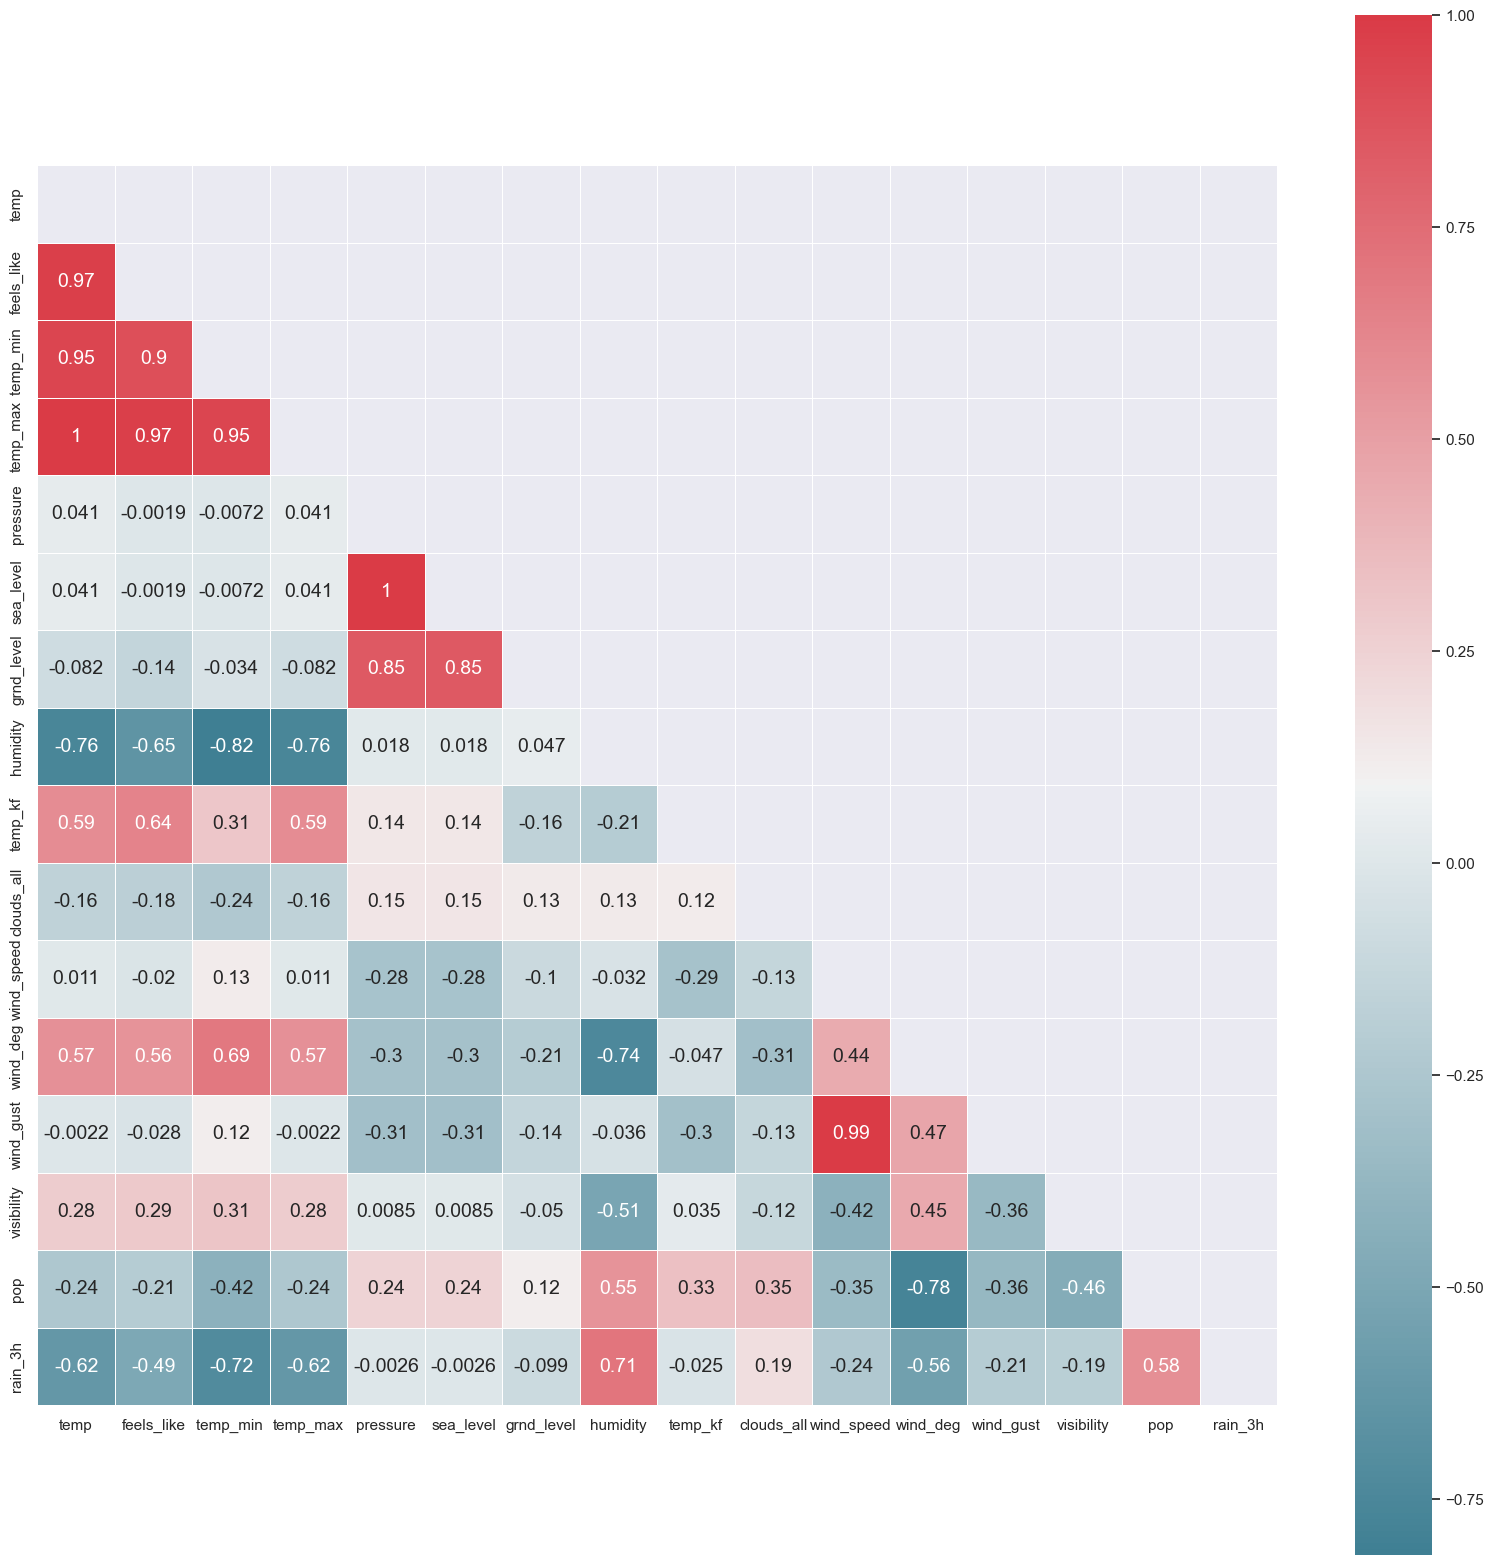

In [35]:
#Multivariate Analysis - Correlation Between Numerical Features
# calculates the correlations
correlation = df.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(20, 20)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=np.bool_))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(correlation, cmap=cmap, mask=mask, square=True, linewidths=.5,
            annot=True, annot_kws={'size':14})

# displays the plot
plt.show()

In [70]:
# suppression des variables calculer apartir de temps et variable à faible correlation
df.drop(columns=['temp_min ',"temp_max","temp_kf","sea_level"], inplace=True)

In [71]:
df.columns 

Index(['temp', 'feels_like', 'pressure', 'grnd_level', 'humidity',
       'weather_main', 'weather_description', 'clouds_all', 'wind_speed',
       'wind_deg', 'wind_gust', 'visibility', 'pop', 'rain_3h', 'sys_pod'],
      dtype='object')

In [72]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [73]:
trainset, testset = train_test_split(df, test_size=0.25, random_state=0)

In [74]:
def onehot_encode(df, columns):
    df = df.copy()
    for column in columns:
        dummies = pd.get_dummies(df[column])
        df = pd.concat([df, dummies], axis=1)
        df.drop(column, axis=1, inplace=True)
    return df

In [44]:
nominal_features = ["weather_main","weather_description","sys_pod"]

In [75]:
# Convert nominal values to binary values
#df.replace("?", np.NaN, inplace=True)
def encodage(df):
  df= onehot_encode(df, nominal_features)
  return df

In [76]:
def normalisation(df):
    scaler = StandardScaler()
    cat_cols, num_cols, cat_but_car = grab_col_names(df)
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

In [80]:
def preprocessing(df):
    df = encodage(df)
    #df = imputation(df)
    df = normalisation(df)
    X = df.drop('temp', axis=1)
    y = df['temp']
    #print(y.value_counts())
    return X, y


In [81]:
X_train, y_train = preprocessing(trainset)

In [82]:
X_test, y_test = preprocessing(testset)

In [83]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30, 21), (10, 18), (30,), (10,))

In [86]:
# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [88]:
# Make predictions
y_pred = model.predict(X_test)


ValueError: Feature shape mismatch, expected: 21, got 18

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
